<a href="https://colab.research.google.com/github/sosier/Adversarial_Robustness_of_Vision_Transformers_CNNs/blob/main/Adversarial_Robustness_of_Vision_Transformers_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis on Adversarial Robustness of Vision Transformers & CNNs
## How Training Decisions Impact Adversarial Robustness

In [2]:
DATA_PATH = "./data/"
GOOGLE_DRIVE_PATH = "/content/drive/"
# Your path may differ edit as necessary:
TRAINING_RUNS_PATH = GOOGLE_DRIVE_PATH + "MyDrive/NNDL/Final_Project/Training_Runs/"
# EDIT ME:
USER = "Sean"
COMPLETED_RANDOM_SEEDS = [8888, 8889, 8891]
RANDOM_SEED = 8888

## Set Up


### Imports

In [3]:
# Install if necessary:
!pip install einops  # For complicated tensor reshaping
!pip install torchattacks  # For generating adversarial attacks
!pip3 install git+https://github.com/ponnhide/patchworklib.git  # For plotting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation

  Cloning https://github.com/ponnhide/patchworklib.git to /tmp/pip-req-build-kjxvkpbf
  Running command git clone --filter=blob:none --quiet https://github.com/ponnhide/patchworklib.git /tmp/pip-req-build-kjxvkpbf
  Resolved https://github.com/ponnhide/patchworklib.git to commit 63b3c2555e7614d60160171677b1d2420867f311
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for patchworklib: filename=patchworklib-0.6.4-py3-none-any.whl size=48500 sha256=b40aa13f85e66866774e38f61771c86374bb324b80bf140917c2509ad0cf4f90
  Stored in directory: /tmp/pip-ephem-wheel-cache-lzibcs8k/wheels/2a/37/00/2f005a0b87e985bdc22f12252950a6c3632f9e16b8837003de
Successfully built patchworklib


In [4]:
# Torch related:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torchattacks
import torchsummary
# Experiment management / misc:
from google.colab import data_table, drive
import os
import json
import pandas as pd
from time import time
import math
from datetime import datetime
import numpy as np
import itertools
from copy import deepcopy
# Plotting related:
from IPython.display import display_png
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import patchworklib as pw
from plotnine import (
    ggplot, aes, geom_line, theme_minimal, ggtitle, xlab, ylab, theme,
    element_text, scale_x_continuous, scale_y_continuous, geom_vline,
    geom_text, annotate, scale_color_manual, scale_color_identity,
    element_blank, theme_void, guides, guide_legend, geom_bar, scale_fill_manual
)
import seaborn as sns

# Display pandas DataFrames as Google Colab Data Tables:
data_table.enable_dataframe_formatter()

# Mount Google Drive on Colab:
drive.mount(GOOGLE_DRIVE_PATH)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

Mounted at /content/drive/
Using cuda


<Figure size 100x100 with 0 Axes>

### Download and Preview Data

In [5]:
# Will only download once
# Without the tranfrom returns PIL Image
train_data = MNIST(DATA_PATH, train=True, download=True, transform=ToTensor())
test_data = MNIST(DATA_PATH, train=False, download=True, transform=ToTensor())

print(f"{len(train_data)=}")
print(f"{len(test_data)=}")
train_data[0][0].shape

100%|██████████| 9912422/9912422 [00:00<00:00, 143935797.75it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38297721.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47601256.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21214397.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

len(train_data)=60000
len(test_data)=10000


torch.Size([1, 28, 28])

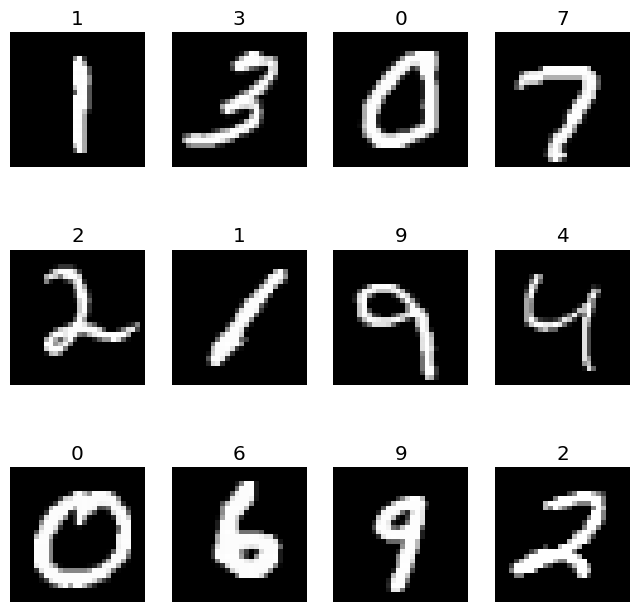

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Model Specification, Training, Testing Helpers

#### Baseline Model Params

In [7]:
VISION_TRANSFORMER_BASELINE = dict(
    train_data=train_data,
    test_data=test_data,
    random_seed=RANDOM_SEED,
    # -------------
    # Model Params:
    # -------------
    model_class="VisionTransformer",
    # Architecture Size Params:
    patch_size=7,
    model_dim=16,
    head_dim=8,
    num_heads=4,
    mlp_dim=32,
    num_layers=2,
    # Other Architecture Params:
    position_embedding="learned",  # Standard per original paper
    QKV_bias=True,
    ## Scaled dot product attention scaling factor. When None, defaults to:
    ## 1/sqrt(head_dim)
    scaling_factor=None,
    activation_function="GELU",  # MLP activation
    # Regularization Params:
    layer_norm_patches=False,
    layer_norm="before",
    dropout=0.0,  # Default to no dropout
    # ----------------
    # Training Params:
    # ----------------
    optimizer="Adam",
    epochs_to_run=5,
    batch_size=128,
    learning_rate=0.001,
    # -----------------------------
    # Testing / Adversarial Params:
    # -----------------------------
    adv_algorithm="PGD",
    eps=8/255,
    alpha=2/255,
    steps=4
)

CNN_BASELINE = dict(
    train_data=train_data,
    test_data=test_data,
    random_seed=RANDOM_SEED,
    # -------------
    # Model Params:
    # -------------
    model_class="CNN",
    conv_layer_1=16,
    conv_layer_2=32,
    conv_layer_3=0,
    conv_kernel=3,
    conv_stride=1,
    conv_padding=1,
    max_pool_kernel=2,
    activation_function="ReLU",
    fully_connected_layer_1=0,
    # Regularization Params:
    conv_normalization="none",
    dropout=0.0,  # Default to no dropout
    # ----------------
    # Training Params:
    # ----------------
    optimizer="Adam",
    epochs_to_run=5,
    batch_size=128,
    learning_rate=0.001,
    # -----------------------------
    # Testing / Adversarial Params:
    # -----------------------------
    adv_algorithm="PGD",
    eps=25/255,
    alpha=5/255,
    steps=10
)

#### Vision Transformer

In [8]:
class ImageToPatches(nn.Module):
    """
    Breaks images (`X`) into square patches of `patch_size` x `patch_size`
    pixels
    """
    def __init__(self, patch_size=7):
        super().__init__()

        self.patch_size = patch_size

        # b, c, h, w = batch_size, channels, height, width
        self.to_patches = Rearrange(
            "b c (h ph) (w pw) -> b (h w) (ph pw c)",
            ph=self.patch_size,
            pw=self.patch_size
        )

    def forward(self, X):
        b, c, h, w = X.shape  # batch_size, channels, height, width
        assert (
            h % self.patch_size == 0 and w % self.patch_size == 0
        ), "image height and width should be divisible by patch_size"

        return self.to_patches(X)

class PositionalEncoding(nn.Module):
    """
    Modified version of standard Transformer positional embedding from PyTorch
    documentation:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.shape[1]]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        in_out_dim,  # a.k.a. model_dim
        head_dim=64,
        num_heads=8,
        layer_norm="before",
        QKV_bias=True,
        # Scaled dot product attention scaling factor. Defaults to:
        # 1/sqrt(head_dim)
        scaling_factor=None,
        dropout=0.0,  # Default to no dropout
        **kwargs
    ):
        super().__init__()

        assert(layer_norm in ("before", "after", "both", "none"))

        self.layer_norm = layer_norm
        if self.layer_norm in ("before", "both"):
            self.layer_norm_before = nn.LayerNorm(in_out_dim)

        # For efficiency calculate Q, K, and V for all heads in one operation:
        self.head_dim = head_dim
        self.num_heads = num_heads
        multihead_dim = self.head_dim * self.num_heads
        self.calc_QKV = nn.Linear(in_out_dim, multihead_dim * 3, bias=QKV_bias)

        self.scaling_factor = scaling_factor
        if not self.scaling_factor:
            self.scaling_factor = self.head_dim**-0.5

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        needs_output_layer = self.num_heads > 1 or self.head_dim != in_out_dim
        self.output = nn.Sequential(
            nn.Linear(multihead_dim, in_out_dim),
            nn.Dropout(dropout)
        ) if needs_output_layer else nn.Identity()

        if self.layer_norm in ("after", "both"):
            self.layer_norm_after = nn.LayerNorm(in_out_dim)

    def forward(self, X):
        batch_size, sequence_length, in_out_dim = X.shape  # b, s, d

        if self.layer_norm in ("before", "both"):
            X = self.layer_norm_before(X)

        # Calculate and reshape Q, K, V:
        Q, K, V = (
            rearrange(
                t,
                "b s (num_heads head_dim) -> b num_heads s head_dim",
                num_heads=self.num_heads,
                head_dim=self.head_dim
            )
            for t in self.calc_QKV(X).chunk(3, dim=-1)
        )

        unnormalized_attention = (Q @ K.transpose(-1, -2)) * self.scaling_factor
        attention_weights = self.softmax(unnormalized_attention)
        attention_weights = self.dropout(attention_weights)

        Z = attention_weights @ V
        # Reshape Z to undo the Q, K, V reshaping above:
        Z = rearrange(
                Z,
                "b num_heads s head_dim -> b s (num_heads head_dim)",
                num_heads=self.num_heads,
                head_dim=self.head_dim
            )

        Z = self.output(Z)

        if self.layer_norm in ("after", "both"):
            Z = self.layer_norm_after(Z)

        return Z

class TransformerMLP(nn.Module):
    def __init__(
        self,
        in_out_dim,  # a.k.a. model_dim
        mlp_dim,
        layer_norm="before",
        activation_function="GELU",  # GELU is standard per original paper
        dropout=0.0,  # Default to no dropout
        **kwargs
    ):
        super().__init__()

        assert(layer_norm in ("before", "after", "both", "none"))

        if type(activation_function) == str:
            assert(activation_function in nn.__dict__), (
                "activation_function must be one of the activation functions " +
                "available in the torch.nn module, e.g. 'ReLU'"
            )
            activation_function = nn.__dict__[activation_function]

        self.layer_norm = layer_norm
        if self.layer_norm in ("before", "both"):
            self.layer_norm_before = nn.LayerNorm(in_out_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_out_dim, mlp_dim),
            activation_function(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, in_out_dim),
            nn.Dropout(dropout)
        )

        if self.layer_norm in ("after", "both"):
            self.layer_norm_after = nn.LayerNorm(in_out_dim)

    def forward(self, X):
        if self.layer_norm in ("before", "both"):
            X = self.layer_norm_before(X)

        X = self.mlp(X)

        if self.layer_norm in ("after", "both"):
            X = self.layer_norm_after(X)

        return X

class TransformerBlock(nn.Module):
    def __init__(self, in_out_dim, **kwargs):
        super().__init__()

        self.multihead_attention = MultiHeadAttention(in_out_dim, **kwargs)
        self.mlp = TransformerMLP(in_out_dim, **kwargs)

    def forward(self, X):
        X = X + self.multihead_attention(X)
        X = X + self.mlp(X)
        return X

class VisionTransformer(nn.Module):
    def __init__(
        self,
        *,
        # Input Details (fixed for MNIST):
        image_channels=1,
        num_classes=10,
        max_patches=28*28,  # For positional embedding
        # Architecture Size Params:
        patch_size=7,
        model_dim=16,
        head_dim=8,
        num_heads=4,
        mlp_dim=32,
        num_layers=2,
        # Other Architecture Params:
        position_embedding="learned",  # Standard per original paper
        QKV_bias=True,
        ## Scaled dot product attention scaling factor. Defaults to:
        ## 1/sqrt(head_dim)
        scaling_factor=None,
        activation_function="GELU",  # MLP activation
        # Regularization Params:
        layer_norm_patches=False,
        layer_norm="before",
        dropout=0.0,  # Default to no dropout
        # Training / Evaluation Params:
        loss_function="cross_entropy",
        **kwargs
    ):
        super().__init__()

        assert(position_embedding in ("learned", "standard_transformer", "none"))

        patch_dim = image_channels * patch_size**2
        self.image_to_patch_embeddings = nn.Sequential(
            ImageToPatches(patch_size),
            nn.LayerNorm(patch_dim) if layer_norm_patches else nn.Identity(),
            nn.Linear(patch_dim, model_dim),
            nn.LayerNorm(model_dim) if layer_norm != "none" else nn.Identity()
        )

        # Token from which we make the final prediction so that we don't bias
        # our result to any particular image patch:
        self.class_token = nn.Parameter(torch.randn(1, 1, model_dim))

        self.position_embedding = position_embedding
        if self.position_embedding == "learned":
            self.add_position_embedding = nn.Parameter(
                torch.randn(1, max_patches + 1, model_dim)
            )
        elif self.position_embedding == "standard_transformer":
            self.add_position_embedding = PositionalEncoding(
                model_dim, dropout, max_len=(max_patches + 1)
            )

        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            TransformerBlock(
                in_out_dim=model_dim,
                head_dim=head_dim,
                num_heads=num_heads,
                mlp_dim=mlp_dim,
                QKV_bias=QKV_bias,
                scaling_factor=scaling_factor,
                activation_function=activation_function,
                layer_norm=layer_norm,
                dropout=dropout
            )
            for _ in range(num_layers)
        ])

        self.layer_norm = layer_norm
        if self.layer_norm != "none":
            self.final_layer_norm = nn.LayerNorm(model_dim)

        self.final_output = nn.Linear(model_dim, num_classes)

        if type(loss_function) == str:
            assert(loss_function in F.__dict__), (
                "loss_function must be one of the loss functions " +
                "available in the torch.nn.functional module, e.g. 'cross_entropy'"
            )
            loss_function = F.__dict__[loss_function]
        self.loss_function = loss_function

    def forward(self, X, targets=None):
        # Embded images:
        X = self.image_to_patch_embeddings(X)
        b, s, m = X.shape  # batch_size, sequence_length, model_dim

        # Attach a class token to each sequence of image patches:
        class_tokens = repeat(self.class_token, "1 1 m -> b 1 m", b=b)
        X = torch.cat((class_tokens, X), dim=1)

        if self.position_embedding == "learned":
            X = X + self.add_position_embedding[:, :(s + 1)]
            X = self.dropout(X)
        elif self.position_embedding == "standard_transformer":
            X = self.add_position_embedding(X)
        else:
            X = self.dropout(X)

        # Run main body of the Transformer:
        for layer in self.layers:
            X = layer(X)

        # Extract class token:
        X = X[:, 0]

        # Output final logits:
        if self.layer_norm != "none":
            X = self.final_layer_norm(X)

        # Final layer's output is the logits:
        logits = self.final_output(X)

        if targets is not None:
            loss = self.loss_function(logits, targets)
            return logits, loss
        else:
            return logits


#### CNN

In [9]:
# For helping manage layer size inputs to CNN:
def layers_dict_to_size_list(layers_dict):
    layer_sizes = []
    for layer in sorted(layers_dict.items()):
        if layer[1]:  # if layer size > 0
            layer_sizes.append(layer[1])
        else:
            break

    return layer_sizes

class CNN(nn.Module):
    def __init__(
        self,
        *,
        # Input Details (fixed for MNIST):
        in_channels=1,
        in_height=28,
        in_width=28,
        num_classes=10,
        loss_function="cross_entropy",
        # Architecutre Params:
        conv_layers=[16, 32],
        conv_kernel=3,
        conv_stride=1,
        conv_padding=1,
        max_pool_kernel=2,
        activation_function="ReLU",
        fully_connected_layers=[],
        # Regularization Params:
        conv_normalization="none",  # Set to False so default is no regularization
        dropout=0.0,  # Set to 0 so default is no regularization
        **kwargs
    ):
        super().__init__()

        # ------------------------
        # Validate / Clean Inputs:
        # ------------------------
        assert(conv_normalization in ("batch", "layer", "none"))

        # Support alternative way of defining of define conv_layers and
        # full_connected_layers that is more convenient for experiments:
        conv_layer_size_params = {
            k: v for k, v in kwargs.items()
            if k.startswith("conv_layer_")
        }
        if len(conv_layer_size_params) > 0:
            conv_layers = layers_dict_to_size_list(conv_layer_size_params)
        assert(len(conv_layers) >= 1)

        fully_connected_layer_size_params = {
            k: v for k, v in kwargs.items()
            if k.startswith("fully_connected_layer_")
        }
        if len(fully_connected_layer_size_params) > 0:
            fully_connected_layers =\
                layers_dict_to_size_list(fully_connected_layer_size_params)

        # If necessary, fetch actual activation function and loss functoon:
        if type(activation_function) == str:
            assert(activation_function in nn.__dict__), (
                "activation_function must be one of the activation functions " +
                "available in the torch.nn module, e.g. 'ReLU'"
            )
            activation_function = nn.__dict__[activation_function]

        if type(loss_function) == str:
            assert(loss_function in F.__dict__), (
                "loss_function must be one of the loss functions " +
                "available in the torch.nn.functional module, e.g. 'cross_entropy'"
            )
            loss_function = F.__dict__[loss_function]
        self.loss_function = loss_function

        # ------------------------------
        # Actually Initialize the Model:
        # ------------------------------
        self.layers = nn.ModuleList()

        # Convolutional Layers:
        for i, layer_out in enumerate(conv_layers):
            layer_in = in_channels if i == 0 else conv_layers[i - 1]
            max_pool_stride = max_pool_kernel

            layer = nn.Sequential(
                nn.Conv2d(
                    in_channels=layer_in,
                    out_channels=layer_out,
                    kernel_size=conv_kernel,
                    stride=conv_stride,
                    padding=conv_padding
                ),
                activation_function(),
                nn.MaxPool2d(
                    kernel_size=max_pool_kernel,
                    stride=max_pool_stride
                )
            )

            # Update height / width:
            in_height, in_width = self.__update_height_width(
                in_height,
                in_width,
                conv_kernel,
                conv_stride,
                conv_padding,
                max_pool_kernel,
                max_pool_stride
            )

            # Normalization (optional):
            if conv_normalization == "batch":
                layer.add_module(f"BatchNorm{i + 1}", nn.BatchNorm2d(layer_out))
            elif conv_normalization == "layer":
                layer.add_module(
                    f"LayerNorm{i + 1}",
                    nn.LayerNorm((layer_out, in_height, in_width)))

            # Dropout (optional):
            if dropout > 0:
                layer.add_module(f"Dropout{i + 1}", nn.Dropout(dropout))

            self.layers.append(layer)

        # Flatten Output:
        self.layers.append(nn.Flatten())

        # Fully Connected Layers:
        for i, layer_out in enumerate(fully_connected_layers):
            if i > 0:
                layer_in = fully_connected_layers[i - 1]
            else:
                layer_in = conv_layers[-1] * in_height * in_width

            layer = nn.Sequential(
                nn.Linear(layer_in, layer_out),
                activation_function()
            )

            self.layers.append(layer)

        # Final Fully Connected Output Layer:
        if len(fully_connected_layers):
            layer_in = fully_connected_layers[-1]
        else:
            layer_in = conv_layers[-1] * in_height * in_width

        self.layers.append(nn.Linear(layer_in, num_classes))

        # Dropout (optional):
        if dropout > 0:
            self.layers.append(nn.Dropout(dropout))

    def __calc_new_height_or_width(self, old, kernel, stride, padding=0, dilation=1):
        """
        Calculate the height or width of an image after applying a convolution or
        max pooling operation

        Based on formulas here:
        https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d:~:text=output.%20Default%3A%20True-,Shape%3A,-Input%3A
        """
        return (old + 2 * padding - dilation * (kernel - 1) - 1) // stride + 1

    def __update_height_width(self,
            height,
            width,
            conv_kernel,
            conv_stride,
            conv_padding,
            max_pool_kernel,
            max_pool_stride
        ):
        # Update height / width:
        # After convolution
        height = self.__calc_new_height_or_width(
            height, conv_kernel, conv_stride, conv_padding
        )
        width = self.__calc_new_height_or_width(
            width, conv_kernel, conv_stride, conv_padding
        )
        # After max pool
        height = self.__calc_new_height_or_width(
            height, max_pool_kernel, max_pool_stride
        )
        width = self.__calc_new_height_or_width(
            width, max_pool_kernel, max_pool_stride
        )

        return height, width

    def forward(self, X, targets=None):
        for layer in self.layers:
            X = layer(X)

        # Final layer's output is the logits:
        logits = X

        if targets is not None:
            loss = self.loss_function(logits, targets)
            return logits, loss
        else:
            return logits


#### Training / Testing Code

In [10]:
def _next_X_y(data_loader):
    global DEVICE
    X, y = next(iter(data_loader))
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    return X, y

def _train_on_batch(model, X, y, optimizer):
    # Put model into training mode:
    model.train()

    # Do forward pass and evaluate loss
    _, loss = model(X, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def _calculate_accuracy_from_logits(logits, target_y):
    return (F.softmax(logits, dim=1).argmax(dim=1) == target_y).float().mean()

def _calculate_reporting_metrics(model, test_data_loader):
    model.eval()
    X, y = _next_X_y(test_data_loader)
    logits, loss = model(X, y)
    accuracy = _calculate_accuracy_from_logits(logits, y)
    return loss, accuracy

def _report_on_batch(model, test_data_loader):
    loss, accuracy = _calculate_reporting_metrics(model, test_data_loader)
    print("loss =", loss.item())
    print("accuracy =", accuracy.item())
    print("")

def _report_on_epoch(model, test_data_loader, epoch_i):
    print(f"After {epoch_i + 1} epoch(s):")
    loss, accuracy = _calculate_reporting_metrics(model, test_data_loader)
    print("  loss =", loss.item())
    print("  accuracy =", accuracy.item())

def _train_for_n_batches(
    model,
    train_data_loader,
    test_data_loader,
    optimizer,
    batches_to_run,
    verbose,
    print_every
):
    batches_run = 0
    for i in range(batches_to_run):
        X, y = _next_X_y(train_data_loader)
        _train_on_batch(model, X, y, optimizer)
        batches_run += 1

        # Reporting
        if verbose and batches_run % print_every == 0:
            _report_on_batch(model, test_data_loader)

def _train_for_n_epoches(
    model,
    train_data_loader,
    test_data_loader,
    optimizer,
    epochs_to_run,
    verbose,
    print_every
):
    global DEVICE
    batches_run = 0
    for i in range(epochs_to_run):
        # For each batch:
        for X, y in train_data_loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            _train_on_batch(model, X, y, optimizer)
            batches_run += 1

            # Reporting
            if verbose and batches_run % print_every == 0:
                _report_on_batch(model, test_data_loader)

        # Print after every epoch
        if i == 0:
            print("=" * 20)
        _report_on_epoch(model, test_data_loader, i)

    print("=" * 20)

def train(
    model,
    train_data,
    test_data,
    optimizer="Adam",
    epochs_to_run=None,  # Train for 1 epoch if no training limit is given
    batches_to_run=None,
    batch_size=128,
    learning_rate=1e-3,
    verbose=False,
    print_every=100,
    **kwargs
):
    # Initialize train /test DataLoaders:
    train_data_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    test_data_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=batch_size * 16,
        shuffle=True
    )

    # Initialize Optimizer:
    if type(optimizer) == str:
        assert(optimizer in torch.optim.__dict__), (
            "optimizer must be one of the optimizers available in the " +
            "torch.optim module, e.g. 'Adam'"
        )
        optimizer = torch.optim.__dict__[optimizer]
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    if not epochs_to_run and not batches_to_run:
        epochs_to_run = 1

    if epochs_to_run:
        _train_for_n_epoches(
            model,
            train_data_loader,
            test_data_loader,
            optimizer,
            epochs_to_run,
            verbose,
            print_every
        )
    else:  # if batches_to_run:
        _train_for_n_batches(
            model,
            train_data_loader,
            test_data_loader,
            optimizer,
            batches_to_run,
            verbose,
            print_every
        )

def test(
        model,
        test_data,
        adv_algorithm="PGD",
        eps=8/255,
        alpha=2/255,
        steps=4,
        num_test_batches=10,
        **kwargs
    ):
    global DEVICE
    if type(adv_algorithm) == str:
        assert(adv_algorithm in torchattacks.__dict__), (
            "adv_algorithm must be one of the algorithms available in the " +
            "torchattacks package, e.g. 'PGD'"
        )
        adv_algorithm = torchattacks.__dict__[adv_algorithm]

    test_data_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=len(test_data)//num_test_batches
    )

    total_loss = 0
    total_accuracy = 0
    total_adv_loss = 0
    total_adv_accuracy = 0

    model.eval()
    for X, y in test_data_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        logits, loss = model(X, y)
        accuracy = _calculate_accuracy_from_logits(logits, y)

        atk = adv_algorithm(model, eps=eps, alpha=alpha, steps=steps)
        adv_images = atk(X, y).to(DEVICE)

        adv_logits, adv_loss = model(adv_images, y)
        adv_accuracy = _calculate_accuracy_from_logits(adv_logits, y)

        total_loss += loss.item()
        total_accuracy += accuracy.item()
        total_adv_loss += adv_loss.item()
        total_adv_accuracy += adv_accuracy.item()

    # Average over the test batches to get final loss, accuracy, etc.
    loss = total_loss / num_test_batches
    accuracy = total_accuracy / num_test_batches
    adv_loss = total_adv_loss / num_test_batches
    adv_accuracy = total_adv_accuracy / num_test_batches

    print("Final result:")
    print("  loss =", loss)
    print("  accuracy =", accuracy)
    print("  adv_loss =", adv_loss)
    print("  adv_accuracy =", adv_accuracy)
    print("=" * 20)

    results = dict(
        loss = loss,
        accuracy = accuracy,
        adv_loss = adv_loss,
        adv_accuracy = adv_accuracy
    )

    return results

#### Experiment Running Helpers

In [11]:
class ExperimentRun():
    def __init__(self, experiment_params):
        self.experiment_params = experiment_params
        self.trained_by = USER

        # Run the experiment:
        self.start_time = time()
        self.initialize_model()
        self.train()
        self.test()

    def initialize_model(self):
        assert(self.experiment_params["model_class"] in globals()), (
            "model_class must be a pytorch Module class loaded into " +
            "globals(), e.g. 'CNN'"
        )
        model_class = globals()[self.experiment_params["model_class"]]

        torch.manual_seed(self.experiment_params["random_seed"])
        self.model = model_class(**self.experiment_params).to(DEVICE)

    def train(self):
        self.train_start_time = time()
        train(self.model, **self.experiment_params)
        self.train_end_time = time()

    def test(self):
        self.results = test(self.model, **self.experiment_params)
        self.end_time = time()
        print(
            f"({round((self.train_end_time - self.train_start_time)/60, 2)} min. training;",
            f"{round((self.end_time - self.start_time)/60, 2)} min. total)\n"
        )

    @property
    def state(self):
        return {
            "trained_by": self.trained_by,
            "start_time": self.start_time,
            "train_start_time": self.train_start_time,
            "train_end_time": self.train_end_time,
            "end_time": self.end_time,
            **{key: value for key, value in self.experiment_params.items()
                if key not in ["train_data", "test_data"]},
            **self.results
        }

In [12]:
def list_to_hashable(l):
    l = deepcopy(l)
    for i, item in enumerate(l):
        if isinstance(item, dict):
            l[i] = dict_to_hashable(item)
        elif isinstance(item, list):
            l[i] = list_to_hashable(item)
    return tuple(l)

def dict_to_hashable(d):
    d = deepcopy(d)
    for key in d.keys():
        if isinstance(d[key], dict):
            d[key] = dict_to_hashable(d[key])
        elif isinstance(d[key], list):
            d[key] = list_to_hashable(d[key])
    return tuple(sorted(d.items()))

class ExperimentStore():
    def __init__(self, data_path=TRAINING_RUNS_PATH):
        self.data_path = data_path
        self._hash_keys = {
            "VisionTransformer": {
                key for key in VISION_TRANSFORMER_BASELINE.keys()
                if key not in ["train_data", "test_data"]
            },
            "CNN": {
                key for key in CNN_BASELINE.keys()
                if key not in ["train_data", "test_data"]
            }
        }
        self.state_data = self.load_state_data()

    def _load_raw_state_data(self, verbose=True):
        all_state_data_path_files = os.listdir(self.data_path)
        state_data_files = [
            file for file in all_state_data_path_files
            if file.endswith(".json")
        ]

        if verbose:
            print("# state files detected =", len(state_data_files))
            print("Loading...")

        data = []
        for file_name in state_data_files:
            with open(self.data_path + file_name, "r") as file:
                data.append(json.load(file))

        if verbose:
            print("# Loaded =", len(data))

        return data

    def hash_keys(self, model_class):
        assert(model_class in ["VisionTransformer", "CNN"])
        return self._hash_keys[model_class]

    def _raw_state_to_hashable(self, raw_state):
        assert("model_class" in raw_state)
        hash_keys = self.hash_keys(raw_state["model_class"])
        hash_state = {
            key: value for key, value in raw_state.items()
            if key in hash_keys
        }
        assert len(hash_state) == len(hash_keys)
        return dict_to_hashable(hash_state)

    def _raw_state_data_to_dict(self, raw_state_data):
        return {
            self._raw_state_to_hashable(raw_state): raw_state
            for raw_state in raw_state_data
        }

    def load_state_data(self):
        return self._raw_state_data_to_dict(self._load_raw_state_data())

    def contains(self, raw_state):
        key = self._raw_state_to_hashable(raw_state)
        return key in self.state_data

    def get(self, raw_state):
        key = self._raw_state_to_hashable(raw_state)
        return self.state_data[key]

    def add(self, raw_state):
        key = self._raw_state_to_hashable(raw_state)
        self.state_data[key] = raw_state

    def save_to_file(self, state, file_path):
        assert(file_path.endswith(".json"))
        if "/" not in file_path:
            file_path = self.data_path + file_path

        print("Saving...")
        with open(file_path, "w") as file:
            json.dump(state, file)
        print("Saved to", file_path)

    def save(self, state, save_to_file=""):
        if not self.contains(state):
            print("Saving state...")
            self.add(state)

        if save_to_file:
            self.save_to_file(state, save_to_file)

    def df(self, cleaning_function=lambda df: df):
        df = pd.DataFrame(self.state_data.values())
        # Clean df and return
        return cleaning_function(df)


In [13]:
class Experiment():
    def __init__(
        self,
        model_class,
        experiment_store,
        save_to_file_format="{trained_by}-{end_time:.0f}.json",
        **kwargs  # kwargs keys = param and values = iterable of values to test
    ):
        assert(model_class in ["VisionTransformer", "CNN"])
        self.model_class = model_class
        self.vars = kwargs
        self.experiment_on_string = "+".join(sorted(self.vars.keys()))

        self.experiment_store = experiment_store
        self.save_to_file_format = save_to_file_format
        self.data = []

        # Actually run the experiment
        self.run()

    def _run_experiment_and_save(self, experiment_params):
        if self.experiment_store.contains(experiment_params):
            print("Loading saved experiment values...")
            state = self.experiment_store.get(experiment_params)
        else:
            # Perform the complete experiment training / testing run:
            state = ExperimentRun(experiment_params).state

            # Save results locally and to file:
            save_to_file = self.save_to_file_format.format(**state)
            self.experiment_store.save(state, save_to_file)

        self.data.append(state)

    def run(self):
        if len(self.vars) == 1:  # Univariate experiment
            for var, allowed_values in self.vars.items():  # Only runs once
                experiments = [{var: value} for value in allowed_values]

        else:  # Multivariate experiment
            # Sort vars for consistent order:
            vars = sorted(self.vars.items())
            # Unzip into the variable id and allowed values:
            vars, allowed = zip(*vars)
            # Calculate every possible combination of the allowed values. Each
            # of these is one experiment of the form:
                # {"var1": var1_val_1, "var2", var2_val_1, ...}
            experiments = [
                dict(zip(vars, combo))
                for combo in itertools.product(*allowed)
            ]

        if self.model_class == "VisionTransformer":
            baseline_params = VISION_TRANSFORMER_BASELINE
        elif self.model_class == "CNN":
            baseline_params = CNN_BASELINE

        for experiment_params in experiments:
            print(f"{self.model_class}:", experiment_params)
            experiment_params = {**baseline_params, **experiment_params}
            self._run_experiment_and_save(experiment_params)

    def df(self, cleaning_function=lambda df: df):
        df = pd.DataFrame(self.data)
        # Clean df and return
        df["safety_capability_ratio"] = df["adv_accuracy"] / df["accuracy"]
        return cleaning_function(df)


#### Plotting Helpers

In [14]:
PARAM_NAMES = dict(
    # -------------
    # Model Params:
    # -------------
    # Architecture Size Params:
    patch_size="Image Patch Size",
    model_dim="Primary Model Dimension",
    head_dim="Attention Head Dimension",
    num_heads="Number of Attention Heads",
    mlp_dim="MLP Dimension",
    num_layers="Number of Layers",
    # Other Architecture Params:
    position_embedding="Positional Embedding",
    QKV_bias="Q, K, V Calculated with Bias Term",
    scaling_factor="Attention Scaling Factor",
    activation_function="MLP Activation Function",
    # Regularization Params:
    layer_norm_patches="Patches Layer Normalized",
    layer_norm="Layer Normalization",
    dropout="Dropout Rate",
    # ----------------
    # Training Params:
    # ----------------
    epochs_to_run="Epochs to Run",
    batch_size="Batch Size",
    learning_rate="Learning Rate",
    # -----------------------------
    # Testing / Adversarial Params:
    # -----------------------------
    eps="Adversarial Budget",
    alpha="Adversarial Step Size",
    steps="Adversarial Steps",
    # --------------------------
    # Other CNN-specific Params:
    # --------------------------
    conv_layer_1="1st Convolutional Layer Size",
    conv_layer_2="2nd Convolutional Layer Size",
    conv_layer_3="3rd Convolutional Layer Size",
    conv_kernel="Convolutional Kernel Size",
    conv_stride="Convolutional Stride",
    conv_padding="Convolutional Padding",
    max_pool_kernel="Max Pooling Kernel Size",
    fully_connected_layer_1="1st Fully Connected Layer Size",
    conv_normalization="Normalization on Convolutional Layers"
)

def to_percents(nums):
    # Modified from version here:
    return ["%d%%" % (num * 100) for num in nums]

def _get_raw_plot_data(
    experiment,
    var,
    baseline_value=None,
    metrics=["accuracy", "adv_accuracy", "safety_capability_ratio"]
):
    # Assemble the plot data:
    df = experiment.df()
    df = df.melt(
        id_vars=["random_seed", var],
        value_vars=metrics,
        var_name="metric",
        value_name="value"
    ).groupby([var, "metric"]).mean()["value"].reset_index()

    var_name = PARAM_NAMES[var]
    x_label = var_name

    model_class = experiment.model_class
    if model_class == "VisionTransformer":
        baseline_params = VISION_TRANSFORMER_BASELINE
    elif model_class == "CNN":
        baseline_params = CNN_BASELINE
    else:
        assert(baseline_value)

    if not baseline_value:
        baseline_value = baseline_params[var]

    return df, var_name, x_label, baseline_value

def plot_line_chart(
    experiment,
    var,
    baseline_value=None,
    hide_legend=False,
    var_is_percent=False,
    log_var=False,
    metrics=["accuracy", "adv_accuracy", "safety_capability_ratio"],
    title=None
):
    # Gather data for plot:
    df, var_name, x_label, baseline_value =\
        _get_raw_plot_data(experiment, var, baseline_value, metrics)

    # Handle log-scale variables:
    if log_var:
        df[var] = np.log10(df[var])
        x_label = x_label + " (10^X)"
        baseline_value = np.log10(baseline_value)

    # To be accurate, this needs to happen after the log calculation:
    x_range = df[var].max() - df[var].min()

    metric_labels = {
        "accuracy": "Accuracy",
        "adv_accuracy": "Adversarial Accuracy",
        "safety_capability_ratio": "Safety Capability Ratio"
    }
    metric_labels = [metric_labels[metric] for metric in metrics]

    # Plot the chart:
    gg = (
        ggplot(df, aes(x=var, y="value", color="metric"))
            + geom_line(size=1)
            + geom_vline(
                aes(xintercept=baseline_value),
                linetype="dashed",
                color="black"
            )
            + annotate(
                "text",
                x=baseline_value,
                y=1,
                label="Baseline",
                ha="left",
                va="bottom",
                nudge_x=x_range * 0.01,
                size=9,
                color="black"
            )
            + theme_minimal()
            + ggtitle(var_name if title is None else title)
            + xlab(x_label)
            + ylab("")
            + scale_y_continuous(labels=to_percents)
            + scale_color_manual(
                name=" ",
                values={
                    "accuracy": "blue",
                    "adv_accuracy": "orange",
                    "safety_capability_ratio": "green"
                },
                labels=metric_labels
            )
            + theme(
                plot_title=element_text(weight="bold"),
                axis_title=element_text(size=10)
            )
    )
    if hide_legend:
        gg += theme(legend_position="none")

    if var_is_percent:
        gg += scale_x_continuous(labels=to_percents)

    return gg

def plot_bar_chart(
    experiment,
    var,
    baseline_value=None,
    hide_legend=False,
    rotate_x_axis_labels=False,
    metrics=["accuracy", "adv_accuracy", "safety_capability_ratio"],
    title=None
):
    # Gather data for plot:
    df, var_name, x_label, baseline_value =\
        _get_raw_plot_data(experiment, var, baseline_value, metrics)

    # Baseline label:
    df[var] = df[var].apply(
        lambda val: str(val) + "\n(Baseline)" if val == baseline_value else str(val)
    )

    metric_labels = {
        "accuracy": "Accuracy",
        "adv_accuracy": "Adversarial Accuracy",
        "safety_capability_ratio": "Safety Capability Ratio"
    }
    metric_labels = [metric_labels[metric] for metric in metrics]

    # Plot the chart:
    gg = (
        ggplot(df, aes(x=var, y="value", fill="metric"))
            + geom_bar(position="dodge", stat="identity")
            + theme_minimal()
            + ggtitle(var_name if title is None else title)
            + xlab(x_label)
            + ylab("")
            + scale_y_continuous(labels=to_percents)
            + scale_fill_manual(
                name=" ",
                values={
                    "accuracy": "blue",
                    "adv_accuracy": "darkorange",
                    "safety_capability_ratio": "green"
                },
                labels=metric_labels
            )
            + theme(
                plot_title=element_text(weight="bold"),
                axis_title=element_text(size=10)
            )
    )
    if hide_legend:
        gg += theme(legend_position="none")
    if rotate_x_axis_labels:
        gg += theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5))

    return gg


## Running Experiments

In [15]:
experiment_store = ExperimentStore()

# state files detected = 1545
Loading...
# Loaded = 1545


### Vision Transformer

In [17]:
shared_vision_transformers_experiment_args = dict(
    model_class="VisionTransformer",
    experiment_store=experiment_store
)

# ============
# Experiments:
# ============
# WARNING: This will be very slow to run if these experiments aren't actaully
# already complete. If they are it will be fast and just load their results.

completed_transformer_experiments = dict(
    layer_norm_patches = Experiment(
        layer_norm_patches=[False, True],
        **shared_vision_transformers_experiment_args
    ),
    patch_size = Experiment(
        patch_size=[2, 4, 7, 14, 28],
        **shared_vision_transformers_experiment_args
    ),
    model_dim = Experiment(
        model_dim=range(4, 64 + 1, 4),
        **shared_vision_transformers_experiment_args
    ),
    head_dim = Experiment(
        head_dim=range(4, 64 + 1, 4),
        **shared_vision_transformers_experiment_args
    ),
    num_heads = Experiment(
        num_heads=range(1, 16 + 1),
        **shared_vision_transformers_experiment_args
    ),
    mlp_dim = Experiment(
        mlp_dim=range(4, 128 + 1, 4),
        **shared_vision_transformers_experiment_args
    ),
    num_layers = Experiment(
        num_layers=range(1, 8 + 1),
        **shared_vision_transformers_experiment_args
    ),
    position_embedding = Experiment(
        position_embedding=["learned", "standard_transformer", "none"],
        **shared_vision_transformers_experiment_args
    ),
    QKV_bias = Experiment(
        QKV_bias=[True, False],
        **shared_vision_transformers_experiment_args
    ),
    scaling_factor = Experiment(
        scaling_factor=[
            None, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2,
            1, 2, 4, 8, 16, 32, 64, 128
        ],
        **shared_vision_transformers_experiment_args
    ),
    activation_function = Experiment(
        activation_function=[
            "ReLU", "Sigmoid", "GELU", "Tanh", "LeakyReLU", "LogSigmoid"
        ],
        **shared_vision_transformers_experiment_args
    ),
    layer_norm = Experiment(
        layer_norm=["before", "after", "both", "none"],
        **shared_vision_transformers_experiment_args
    ),
    dropout = Experiment(
        dropout=[n / 100 for n in range(0, 100 + 1, 5)],
        **shared_vision_transformers_experiment_args
    ),
    epochs_to_run = Experiment(
        epochs_to_run=range(1, 21),
        **shared_vision_transformers_experiment_args
    ),
    batch_size = Experiment(
        batch_size=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1028, 2048],
        **shared_vision_transformers_experiment_args
    ),
    learning_rate = Experiment(
        learning_rate=[1*10**(-i) for i in range(7)],
        **shared_vision_transformers_experiment_args
    ),
    eps = Experiment(
        eps=[8/255] + [n / 100 for n in range(0, 100 + 1, 5)],
        **shared_vision_transformers_experiment_args
    ),
    alpha = Experiment(
        alpha=[2/255] + [n / 100 for n in range(0, 50 + 1, 2)],
        **shared_vision_transformers_experiment_args
    ),
    steps = Experiment(
        steps=range(1, 21),
        **shared_vision_transformers_experiment_args
    )
)



VisionTransformer: {'layer_norm_patches': False}
Loading saved experiment values...
VisionTransformer: {'layer_norm_patches': True}
Loading saved experiment values...
VisionTransformer: {'patch_size': 2}
Loading saved experiment values...
VisionTransformer: {'patch_size': 4}
Loading saved experiment values...
VisionTransformer: {'patch_size': 7}
Loading saved experiment values...
VisionTransformer: {'patch_size': 14}
Loading saved experiment values...
VisionTransformer: {'patch_size': 28}
Loading saved experiment values...
VisionTransformer: {'model_dim': 4}
Loading saved experiment values...
VisionTransformer: {'model_dim': 8}
Loading saved experiment values...
VisionTransformer: {'model_dim': 12}
Loading saved experiment values...
VisionTransformer: {'model_dim': 16}
Loading saved experiment values...
VisionTransformer: {'model_dim': 20}
Loading saved experiment values...
VisionTransformer: {'model_dim': 24}
Loading saved experiment values...
VisionTransformer: {'model_dim': 28}
Load

### CNN

In [ ]:
shared_cnn_experiment_args = dict(
    model_class="CNN",
    experiment_store=experiment_store
)

# ============
# Experiments:
# ============
# WARNING: This will be very slow to run if these experiments aren't actaully
# already complete. If they are it will be fast and just load their results.

completed_cnn_experiments = dict(
    conv_layer_1 = Experiment(
        conv_layer_1=range(4, 64 + 1, 4),
        **shared_cnn_experiment_args
    ),
    conv_layer_2 = Experiment(
        conv_layer_2=range(8, 128 + 1, 8),
        **shared_cnn_experiment_args
    ),
    conv_layer_3 = Experiment(
        conv_layer_3=range(0, 256 + 1, 16),
        **shared_cnn_experiment_args
    ),
    conv_kernel = Experiment(
        conv_kernel=range(2, 11 + 1),  # 11 = Max kernel size where baseline has no issues
        **shared_cnn_experiment_args
    ),
    conv_stride = Experiment(
        conv_stride=range(1, 3 + 1),
        **shared_cnn_experiment_args
    ),
    fully_connected_layer_1 = Experiment(
        fully_connected_layer_1=range(0, 128 + 1, 8),
        **shared_cnn_experiment_args
    ),
    activation_function = Experiment(
        activation_function=[
            "ReLU", "Sigmoid", "GELU", "Tanh", "LeakyReLU", "LogSigmoid"
        ],
        **shared_cnn_experiment_args
    ),
    conv_normalization = Experiment(
        conv_normalization=["none", "batch", "layer"],
        **shared_cnn_experiment_args
    ),
    dropout = Experiment(
        dropout=[n / 100 for n in range(0, 100 + 1, 5)],
        **shared_cnn_experiment_args
    ),
    epochs_to_run = Experiment(
        epochs_to_run=range(1, 21),
        **shared_cnn_experiment_args
    ),
    batch_size = Experiment(
        batch_size=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1028, 2048],
        **shared_cnn_experiment_args
    ),
    learning_rate = Experiment(
        learning_rate=[1*10**(-i) for i in range(7)],
        **shared_cnn_experiment_args
    ),
    eps = Experiment(
        eps=[8/255] + [n / 100 for n in range(0, 100 + 1, 5)],
        **shared_cnn_experiment_args
    ),
    alpha = Experiment(
        alpha=[2/255] + [n / 100 for n in range(0, 50 + 1, 2)],
        **shared_cnn_experiment_args
    ),
    steps = Experiment(
        steps=range(1, 21),
        **shared_cnn_experiment_args
    )
)

CNN: {'conv_layer_1': 4}
Loading saved experiment values...
CNN: {'conv_layer_1': 8}
Loading saved experiment values...
CNN: {'conv_layer_1': 12}
Loading saved experiment values...
CNN: {'conv_layer_1': 16}
Loading saved experiment values...
CNN: {'conv_layer_1': 20}
Loading saved experiment values...
CNN: {'conv_layer_1': 24}
Loading saved experiment values...
CNN: {'conv_layer_1': 28}
Loading saved experiment values...
CNN: {'conv_layer_1': 32}
Loading saved experiment values...
CNN: {'conv_layer_1': 36}
Loading saved experiment values...
CNN: {'conv_layer_1': 40}
Loading saved experiment values...
CNN: {'conv_layer_1': 44}
Loading saved experiment values...
CNN: {'conv_layer_1': 48}
Loading saved experiment values...
CNN: {'conv_layer_1': 52}
Loading saved experiment values...
CNN: {'conv_layer_1': 56}
Loading saved experiment values...
CNN: {'conv_layer_1': 60}
Loading saved experiment values...
CNN: {'conv_layer_1': 64}
Loading saved experiment values...
CNN: {'conv_layer_2': 8}
L

## Plotting Results

### Loading All Completed Experiments

In [ ]:
shared_vision_transformers_experiment_args = dict(
    model_class="VisionTransformer",
    random_seed=COMPLETED_RANDOM_SEEDS,
    experiment_store=experiment_store
)

shared_cnn_experiment_args = dict(
    model_class="CNN",
    random_seed=COMPLETED_RANDOM_SEEDS,
    experiment_store=experiment_store
)

completed_transformer_experiments = dict(
    layer_norm_patches = Experiment(
        layer_norm_patches=[False, True],
        **shared_vision_transformers_experiment_args
    ),
    patch_size = Experiment(
        patch_size=[2, 4, 7, 14, 28],
        **shared_vision_transformers_experiment_args
    ),
    model_dim = Experiment(
        model_dim=range(4, 64 + 1, 4),
        **shared_vision_transformers_experiment_args
    ),
    head_dim = Experiment(
        head_dim=range(4, 64 + 1, 4),
        **shared_vision_transformers_experiment_args
    ),
    num_heads = Experiment(
        num_heads=range(1, 16 + 1),
        **shared_vision_transformers_experiment_args
    ),
    mlp_dim = Experiment(
        mlp_dim=range(4, 128 + 1, 4),
        **shared_vision_transformers_experiment_args
    ),
    num_layers = Experiment(
        num_layers=range(1, 8 + 1),
        **shared_vision_transformers_experiment_args
    ),
    position_embedding = Experiment(
        position_embedding=["learned", "standard_transformer", "none"],
        **shared_vision_transformers_experiment_args
    ),
    QKV_bias = Experiment(
        QKV_bias=[True, False],
        **shared_vision_transformers_experiment_args
    ),
    scaling_factor = Experiment(
        scaling_factor=[
            None, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2,
            1, 2, 4, 8, 16, 32, 64, 128
        ],
        **shared_vision_transformers_experiment_args
    ),
    activation_function = Experiment(
        activation_function=[
            "ReLU", "Sigmoid", "GELU", "Tanh", "LeakyReLU", "LogSigmoid"
        ],
        **shared_vision_transformers_experiment_args
    ),
    layer_norm = Experiment(
        layer_norm=["before", "after", "both", "none"],
        **shared_vision_transformers_experiment_args
    ),
    dropout = Experiment(
        dropout=[n / 100 for n in range(0, 100 + 1, 5)],
        **shared_vision_transformers_experiment_args
    ),
    epochs_to_run = Experiment(
        epochs_to_run=range(1, 21),
        **shared_vision_transformers_experiment_args
    ),
    batch_size = Experiment(
        batch_size=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1028, 2048],
        **shared_vision_transformers_experiment_args
    ),
    learning_rate = Experiment(
        learning_rate=[1*10**(-i) for i in range(7)],
        **shared_vision_transformers_experiment_args
    ),
    eps = Experiment(
        eps=[8/255] + [n / 100 for n in range(0, 100 + 1, 5)],
        **shared_vision_transformers_experiment_args
    ),
    alpha = Experiment(
        alpha=[2/255] + [n / 100 for n in range(0, 50 + 1, 2)],
        **shared_vision_transformers_experiment_args
    ),
    steps = Experiment(
        steps=range(1, 21),
        **shared_vision_transformers_experiment_args
    )
)

completed_cnn_experiments = dict(
    conv_layer_1 = Experiment(
        conv_layer_1=range(4, 64 + 1, 4),
        **shared_cnn_experiment_args
    ),
    conv_layer_2 = Experiment(
        conv_layer_2=range(8, 128 + 1, 8),
        **shared_cnn_experiment_args
    ),
    conv_layer_3 = Experiment(
        conv_layer_3=range(0, 256 + 1, 16),
        **shared_cnn_experiment_args
    ),
    conv_kernel = Experiment(
        conv_kernel=range(2, 11 + 1),  # 11 = Max kernel size where baseline has no issues
        **shared_cnn_experiment_args
    ),
    conv_stride = Experiment(
        conv_stride=range(1, 3 + 1),
        **shared_cnn_experiment_args
    ),
    fully_connected_layer_1 = Experiment(
        fully_connected_layer_1=range(0, 128 + 1, 8),
        **shared_cnn_experiment_args
    ),
    activation_function = Experiment(
        activation_function=[
            "ReLU", "Sigmoid", "GELU", "Tanh", "LeakyReLU", "LogSigmoid"
        ],
        **shared_cnn_experiment_args
    ),
    conv_normalization = Experiment(
        conv_normalization=["none", "batch", "layer"],
        **shared_cnn_experiment_args
    ),
    dropout = Experiment(
        dropout=[n / 100 for n in range(0, 100 + 1, 5)],
        **shared_cnn_experiment_args
    ),
    epochs_to_run = Experiment(
        epochs_to_run=range(1, 21),
        **shared_cnn_experiment_args
    ),
    batch_size = Experiment(
        batch_size=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1028, 2048],
        **shared_cnn_experiment_args
    ),
    learning_rate = Experiment(
        learning_rate=[1*10**(-i) for i in range(7)],
        **shared_cnn_experiment_args
    ),
    eps = Experiment(
        eps=[8/255] + [n / 100 for n in range(0, 100 + 1, 5)],
        **shared_cnn_experiment_args
    ),
    alpha = Experiment(
        alpha=[2/255] + [n / 100 for n in range(0, 50 + 1, 2)],
        **shared_cnn_experiment_args
    ),
    steps = Experiment(
        steps=range(1, 21),
        **shared_cnn_experiment_args
    )
)

VisionTransformer: {'layer_norm_patches': False, 'random_seed': 8888}
Loading saved experiment values...
VisionTransformer: {'layer_norm_patches': False, 'random_seed': 8889}
Loading saved experiment values...
VisionTransformer: {'layer_norm_patches': False, 'random_seed': 8891}
Loading saved experiment values...
VisionTransformer: {'layer_norm_patches': True, 'random_seed': 8888}
Loading saved experiment values...
VisionTransformer: {'layer_norm_patches': True, 'random_seed': 8889}
Loading saved experiment values...
VisionTransformer: {'layer_norm_patches': True, 'random_seed': 8891}
Loading saved experiment values...
VisionTransformer: {'patch_size': 2, 'random_seed': 8888}
Loading saved experiment values...
VisionTransformer: {'patch_size': 2, 'random_seed': 8889}
Loading saved experiment values...
VisionTransformer: {'patch_size': 2, 'random_seed': 8891}
Loading saved experiment values...
VisionTransformer: {'patch_size': 4, 'random_seed': 8888}
Loading saved experiment values...
V

### Individual Plots

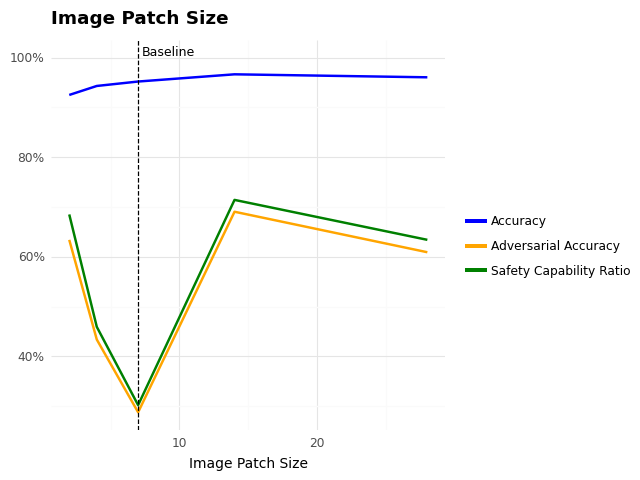

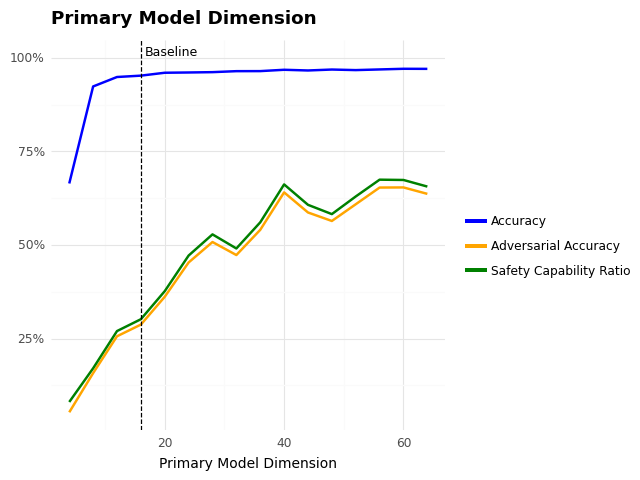

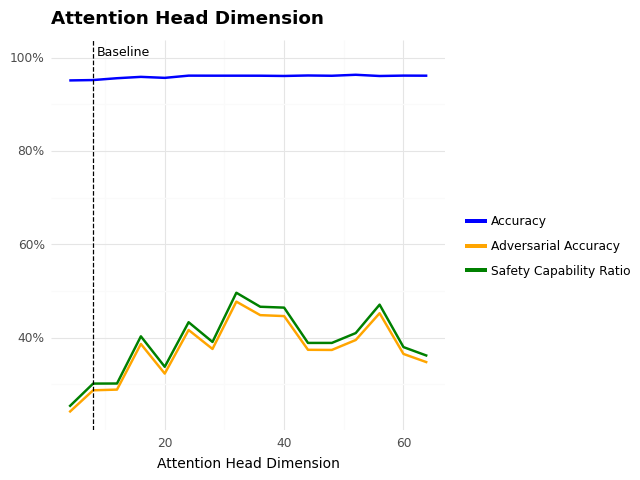

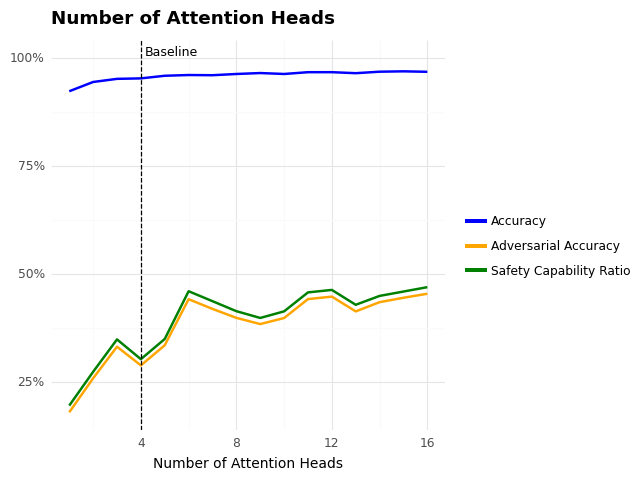

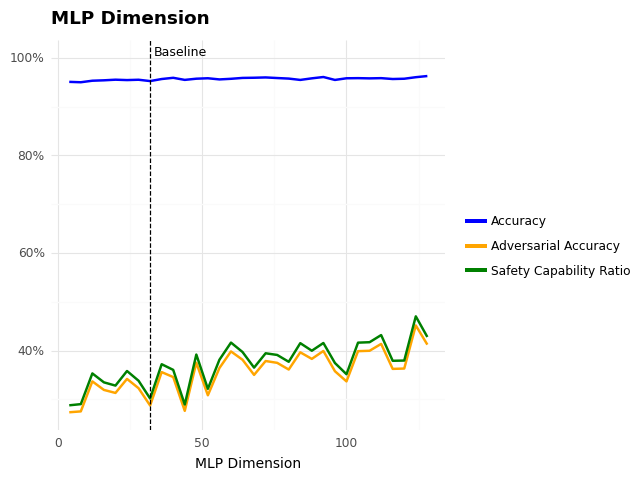

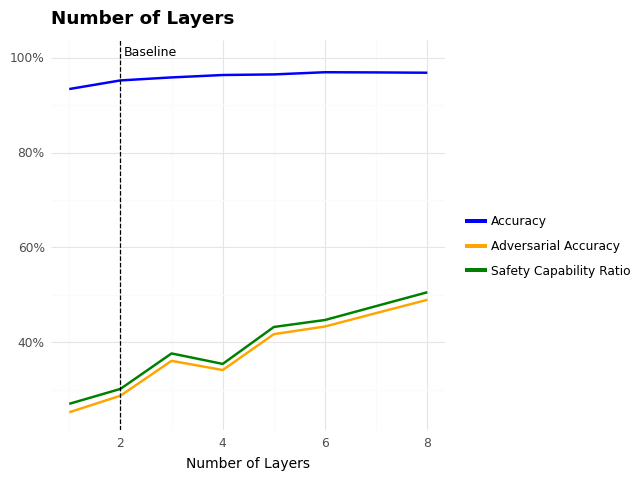

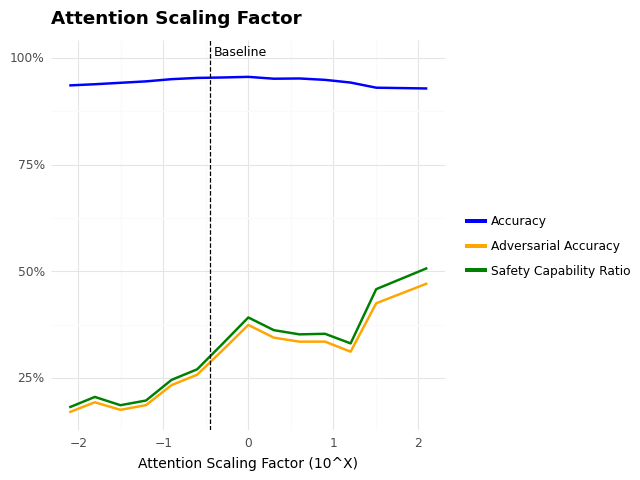

In [ ]:
vars_to_plot = [
    "patch_size",
    "model_dim",
    "head_dim",
    "num_heads",
    "mlp_dim",
    "num_layers",
    "scaling_factor"
]
for var in vars_to_plot:
    print(plot_line_chart(
        completed_transformer_experiments[var],
        var,
        baseline_value=1/np.sqrt(8) if var == "scaling_factor" else None,
        log_var=(var == "scaling_factor")
    ))

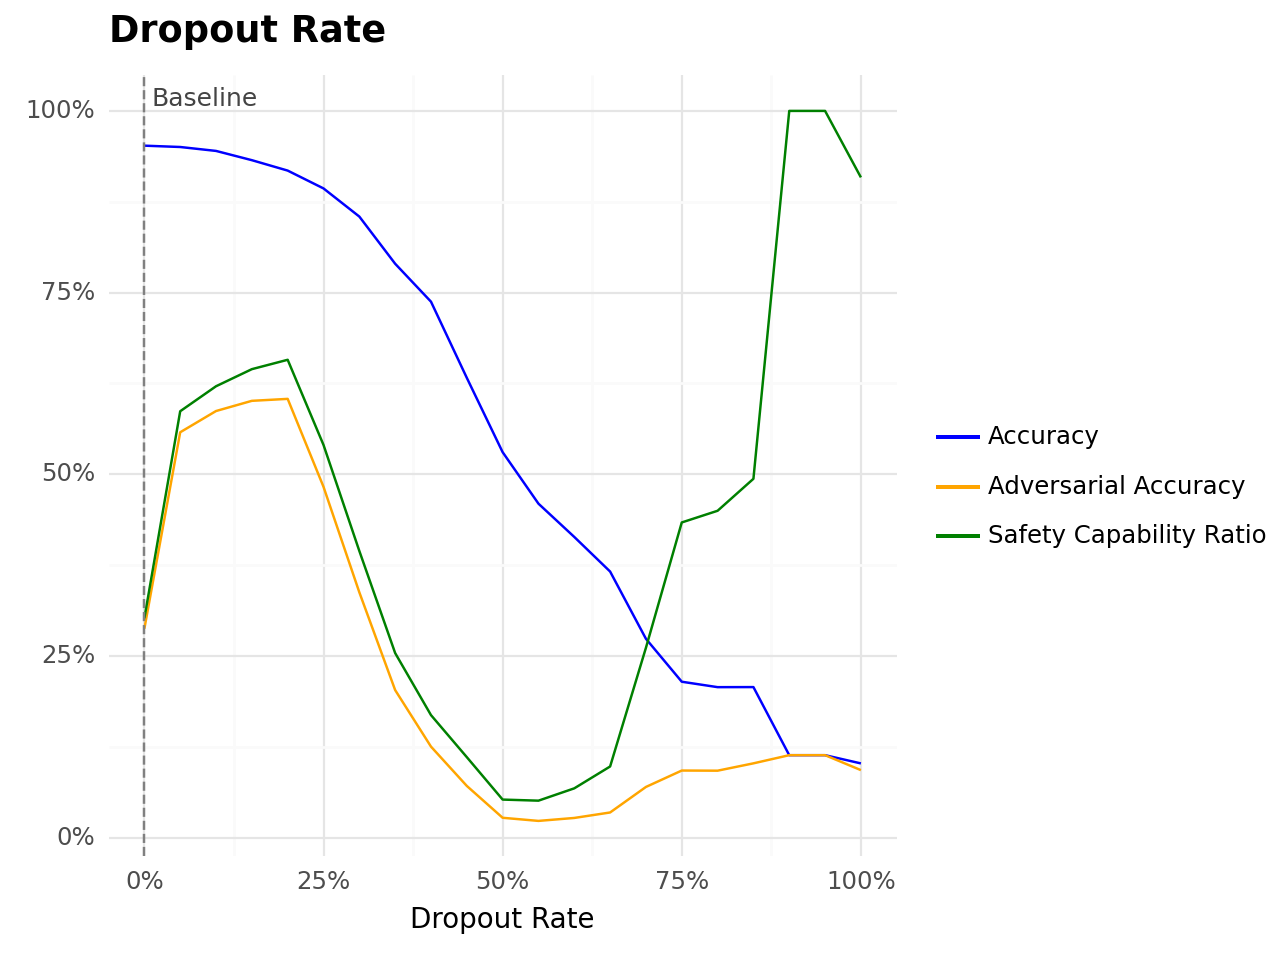

In [ ]:
print(plot_line_chart(
    completed_transformer_experiments["dropout"],
    "dropout",
    var_is_percent=True
))

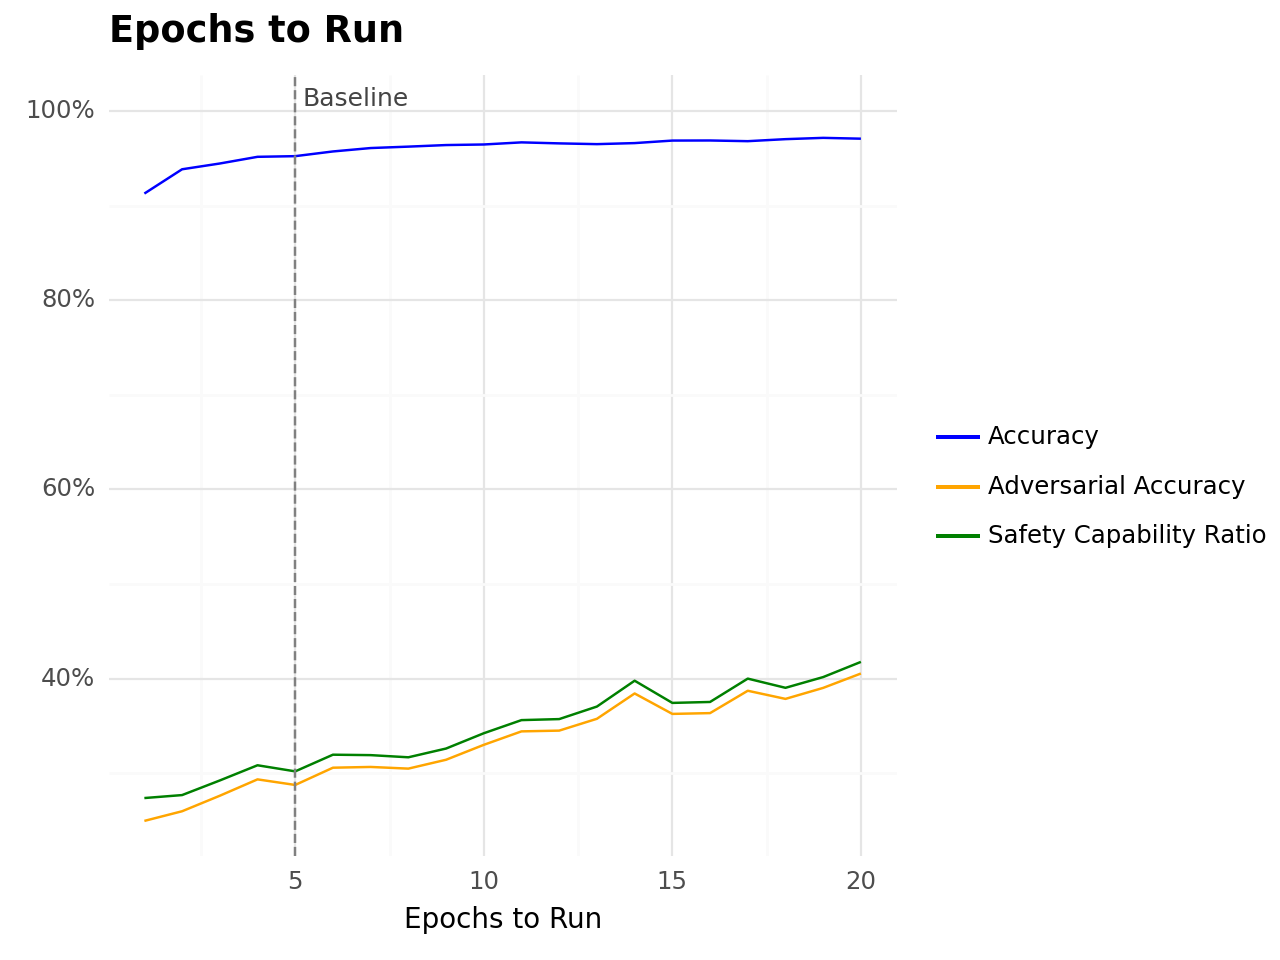

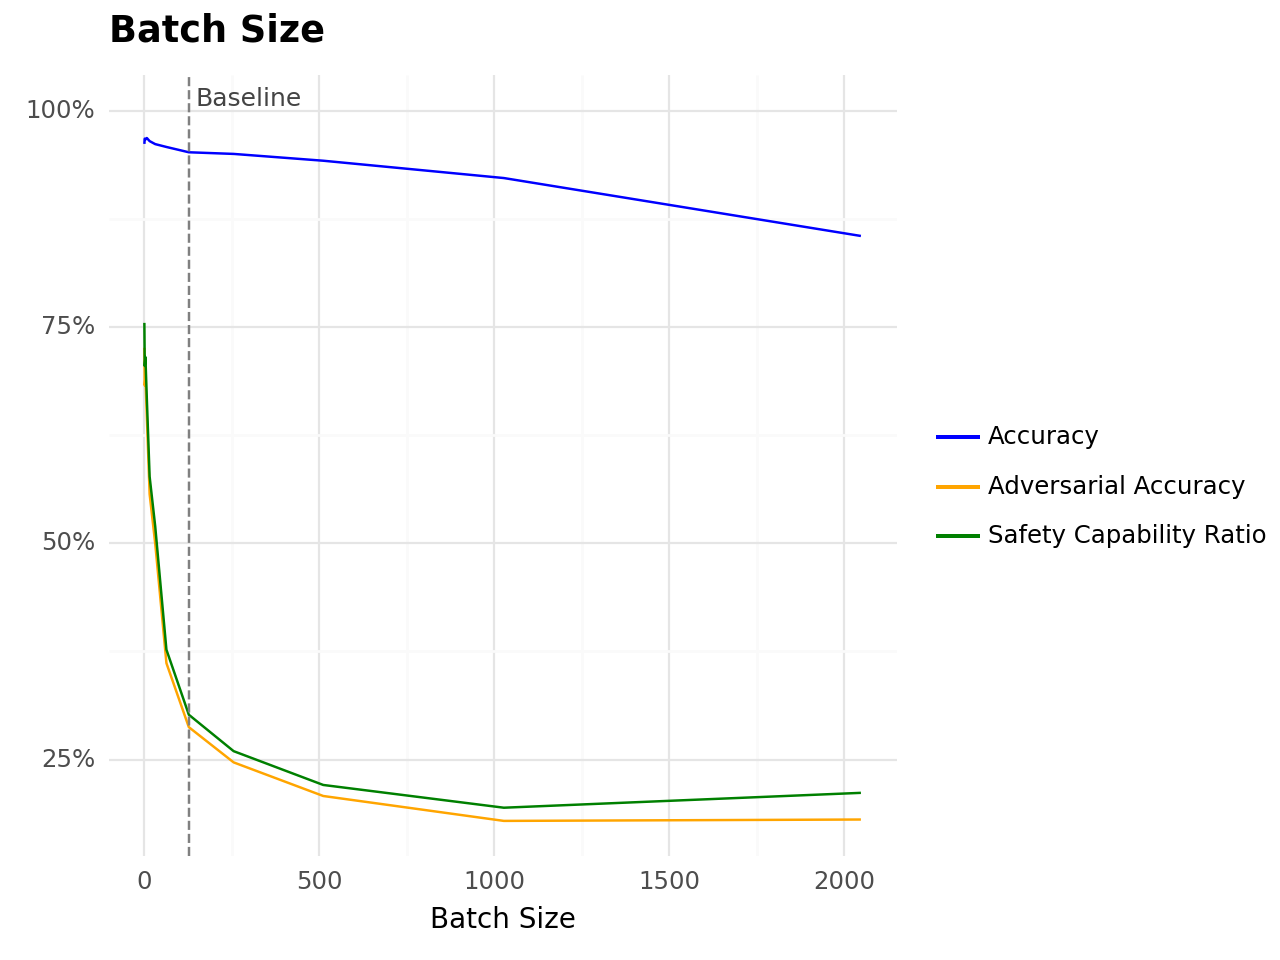

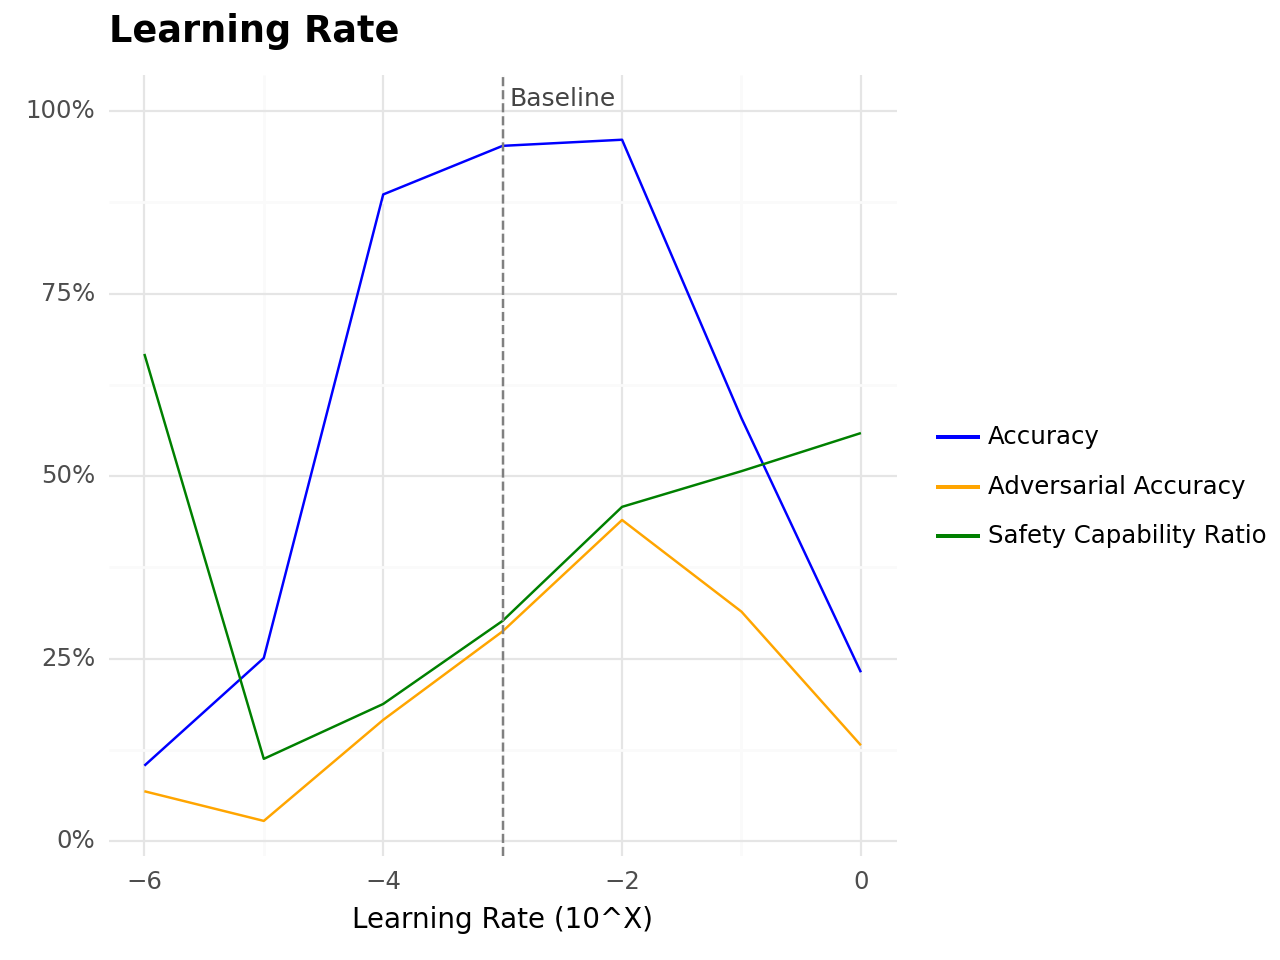

In [ ]:
for var in ["epochs_to_run", "batch_size", "learning_rate"]:
    print(plot_line_chart(
        completed_transformer_experiments[var],
        var,
        log_var=(var == "learning_rate")
    ))

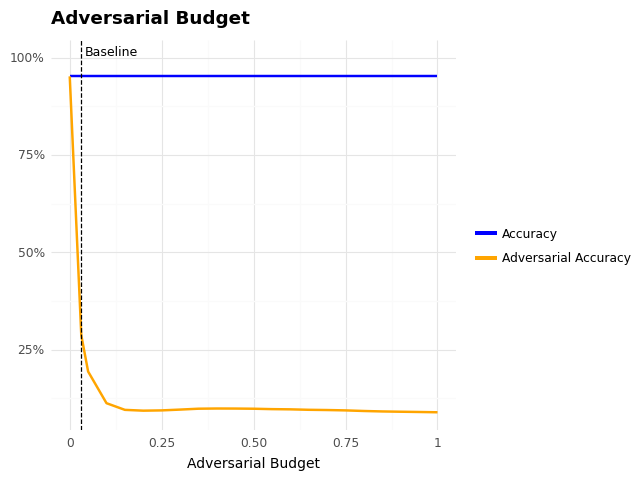

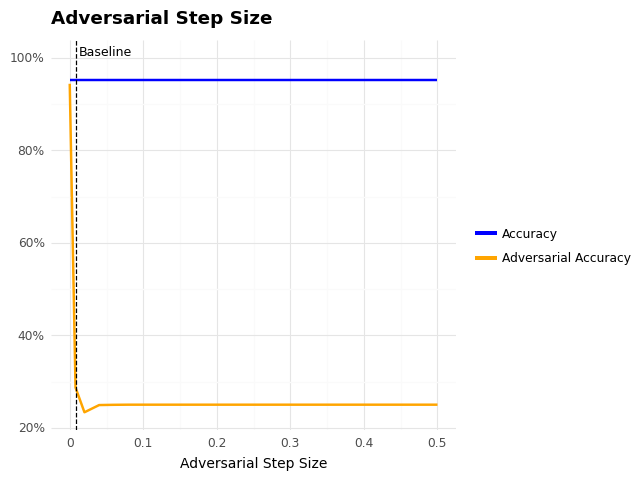

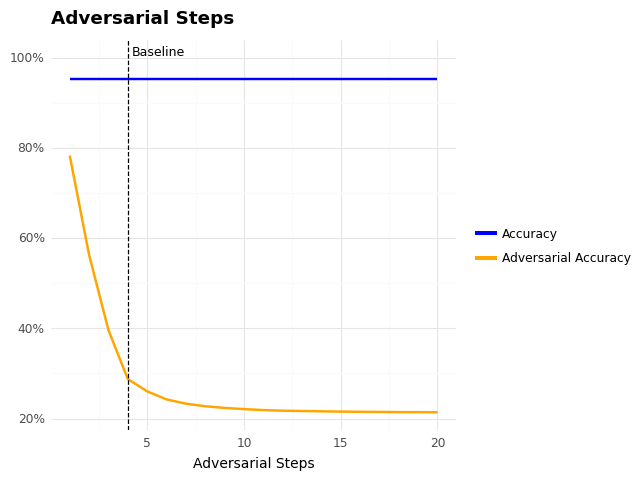

In [ ]:
for var in ["eps", "alpha", "steps"]:
    print(plot_line_chart(
        completed_transformer_experiments[var],
        var,
        metrics=["accuracy", "adv_accuracy"]
    ))

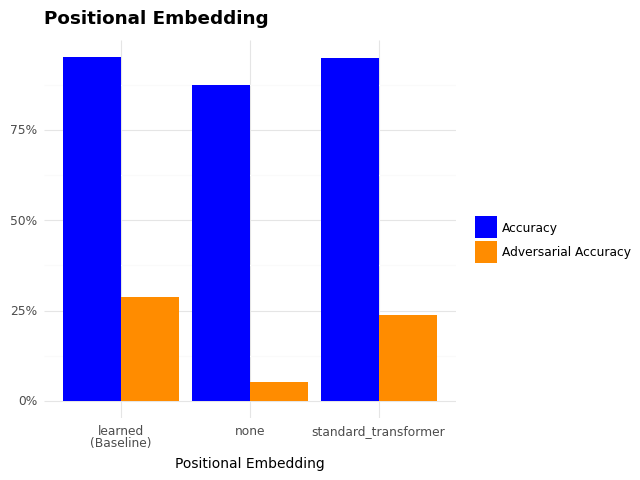

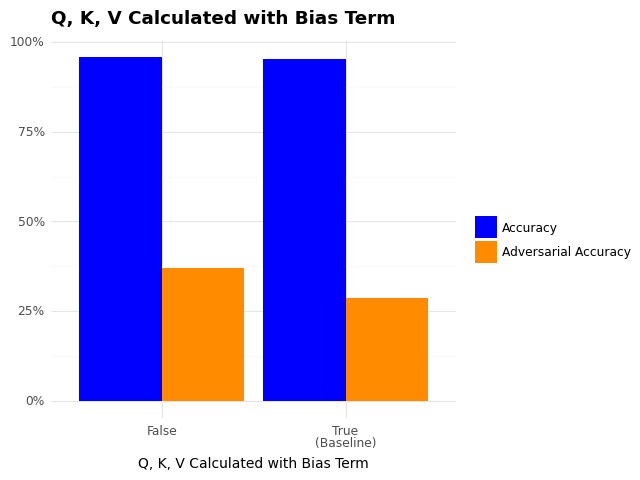

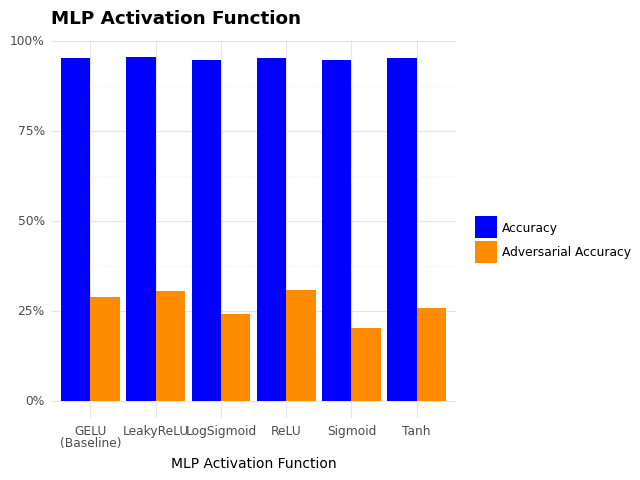

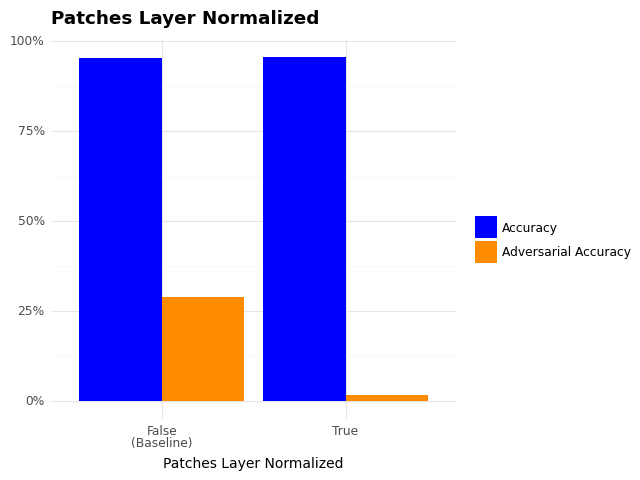

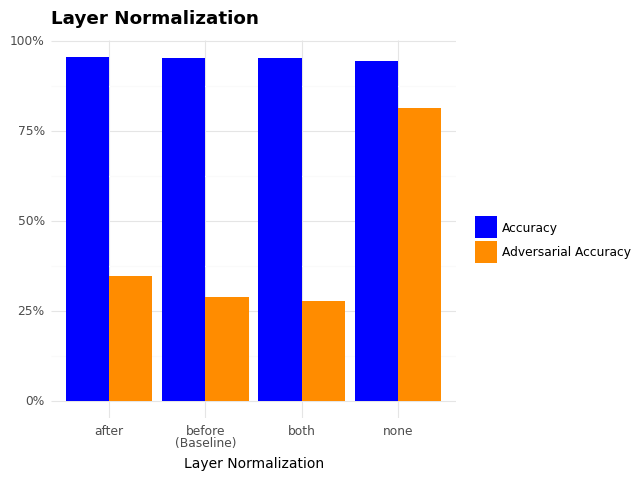

In [ ]:
bar_chart_vars = [
    "position_embedding",
    "QKV_bias",
    "activation_function",
    "layer_norm_patches",
    "layer_norm"
]
for var in bar_chart_vars:
    print(plot_bar_chart(
        completed_transformer_experiments[var],
        var,
        metrics=["accuracy", "adv_accuracy"]
    ))

### Compile Results Plots in One Big Summary Plot

In [ ]:
def combined_summary_plot(
    completed_experiments,
    vars_to_plot,
    plot_kwargs,
    num_rows,
    metrics=["accuracy", "adv_accuracy", "safety_capability_ratio"]
):
    metric_labels = {
        "accuracy": "Accuracy",
        "adv_accuracy": "Adversarial Accuracy",
        "safety_capability_ratio": "Safety Capability Ratio"
    }
    metric_labels = [metric_labels[metric] for metric in metrics]

    legend_only = (
        ggplot(
            pd.DataFrame({"metric": metrics}),
            aes(x=0, y=0, color="metric")
        )
        + geom_line()
        + scale_color_manual(
            name=" ",
            values={
                "accuracy": "blue",
                "adv_accuracy": "orange",
                "safety_capability_ratio": "green"
            },
            labels=metric_labels
        )
        + theme_void()
        + theme(legend_position=(0.5, 0.5), legend_direction="vertical")
    )

    blank_plot = ggplot() + theme_void()

    plots = [
        plot_line_chart(
            completed_experiments[var],
            var,
            metrics=metrics,
            hide_legend=True,
            **plot_kwargs.get(var, {})
        )
        if var not in bar_chart_vars
        else plot_bar_chart(
            completed_experiments[var],
            var,
            metrics=metrics,
            hide_legend=True,
            **plot_kwargs.get(var, {})
        )
        for i, var in enumerate(vars_to_plot)
    ] + [legend_only]
    plots += [blank_plot for _ in range(len(plots) % num_rows)]

    size_of_each_plot = (3, 3)
    for i, row in enumerate(np.array_split(plots, num_rows)):
        for j, gg in enumerate(row):
            if j == 0:
                combined_row = pw.load_ggplot(gg, figsize=size_of_each_plot)
            else:
                combined_row |= pw.load_ggplot(gg, figsize=size_of_each_plot)

        if i == 0:
            combined_plot = combined_row
        else:
            combined_plot /= combined_row

    return combined_plot

#### Vision Transformer

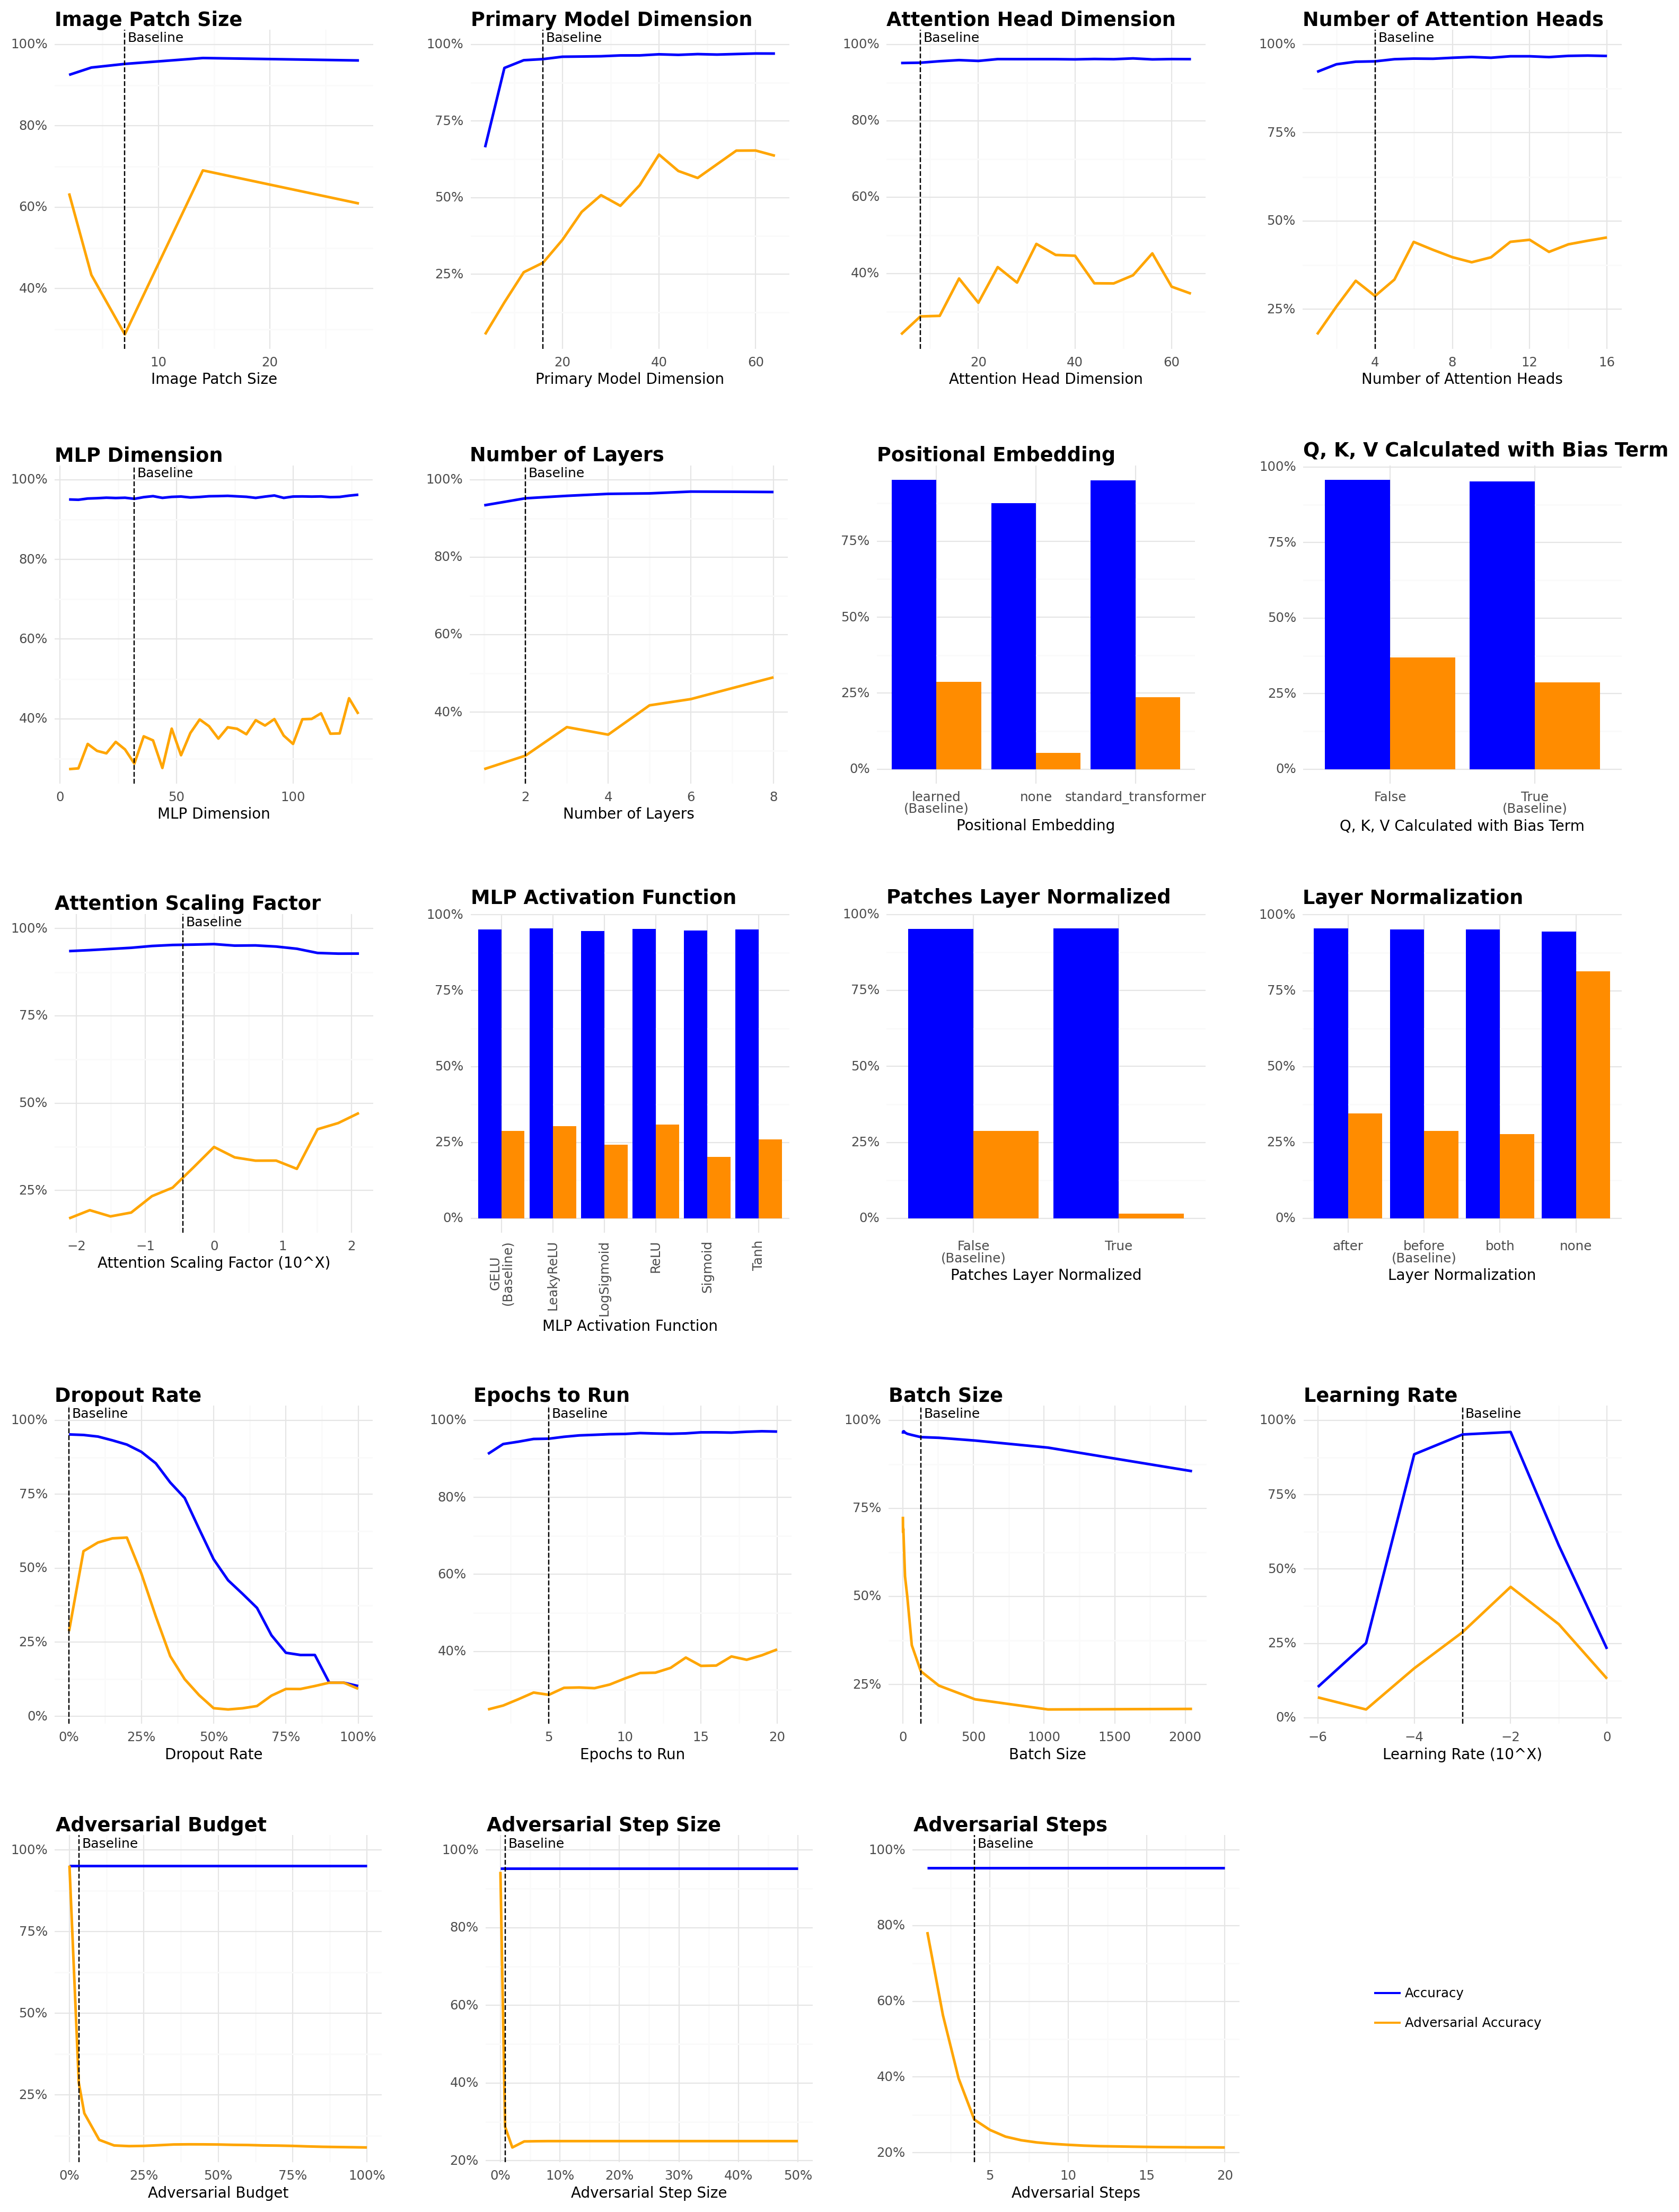

In [ ]:
bar_chart_vars = [
    "position_embedding",
    "QKV_bias",
    "activation_function",
    "layer_norm_patches",
    "layer_norm"
]
vars_to_plot = [
    "patch_size",
    "model_dim",
    "head_dim",
    "num_heads",
    "mlp_dim",
    "num_layers",
    "position_embedding",
    "QKV_bias",
    "scaling_factor",
    "activation_function",
    "layer_norm_patches",
    "layer_norm",
    "dropout",
    "epochs_to_run",
    "batch_size",
    "learning_rate",
    "eps",
    "alpha",
    "steps"
]
plot_kwargs = {
    "scaling_factor": {"baseline_value": 1/np.sqrt(8), "log_var": True},
    "activation_function": {"rotate_x_axis_labels": True},
    "dropout": {"var_is_percent": True},
    "learning_rate": {"log_var": True},
    "eps": {"var_is_percent": True},
    "alpha": {"var_is_percent": True}
}

combined_summary_plot(
    completed_transformer_experiments,
    vars_to_plot,
    plot_kwargs,
    metrics=["accuracy", "adv_accuracy"],
    num_rows=5
)

#### CNN

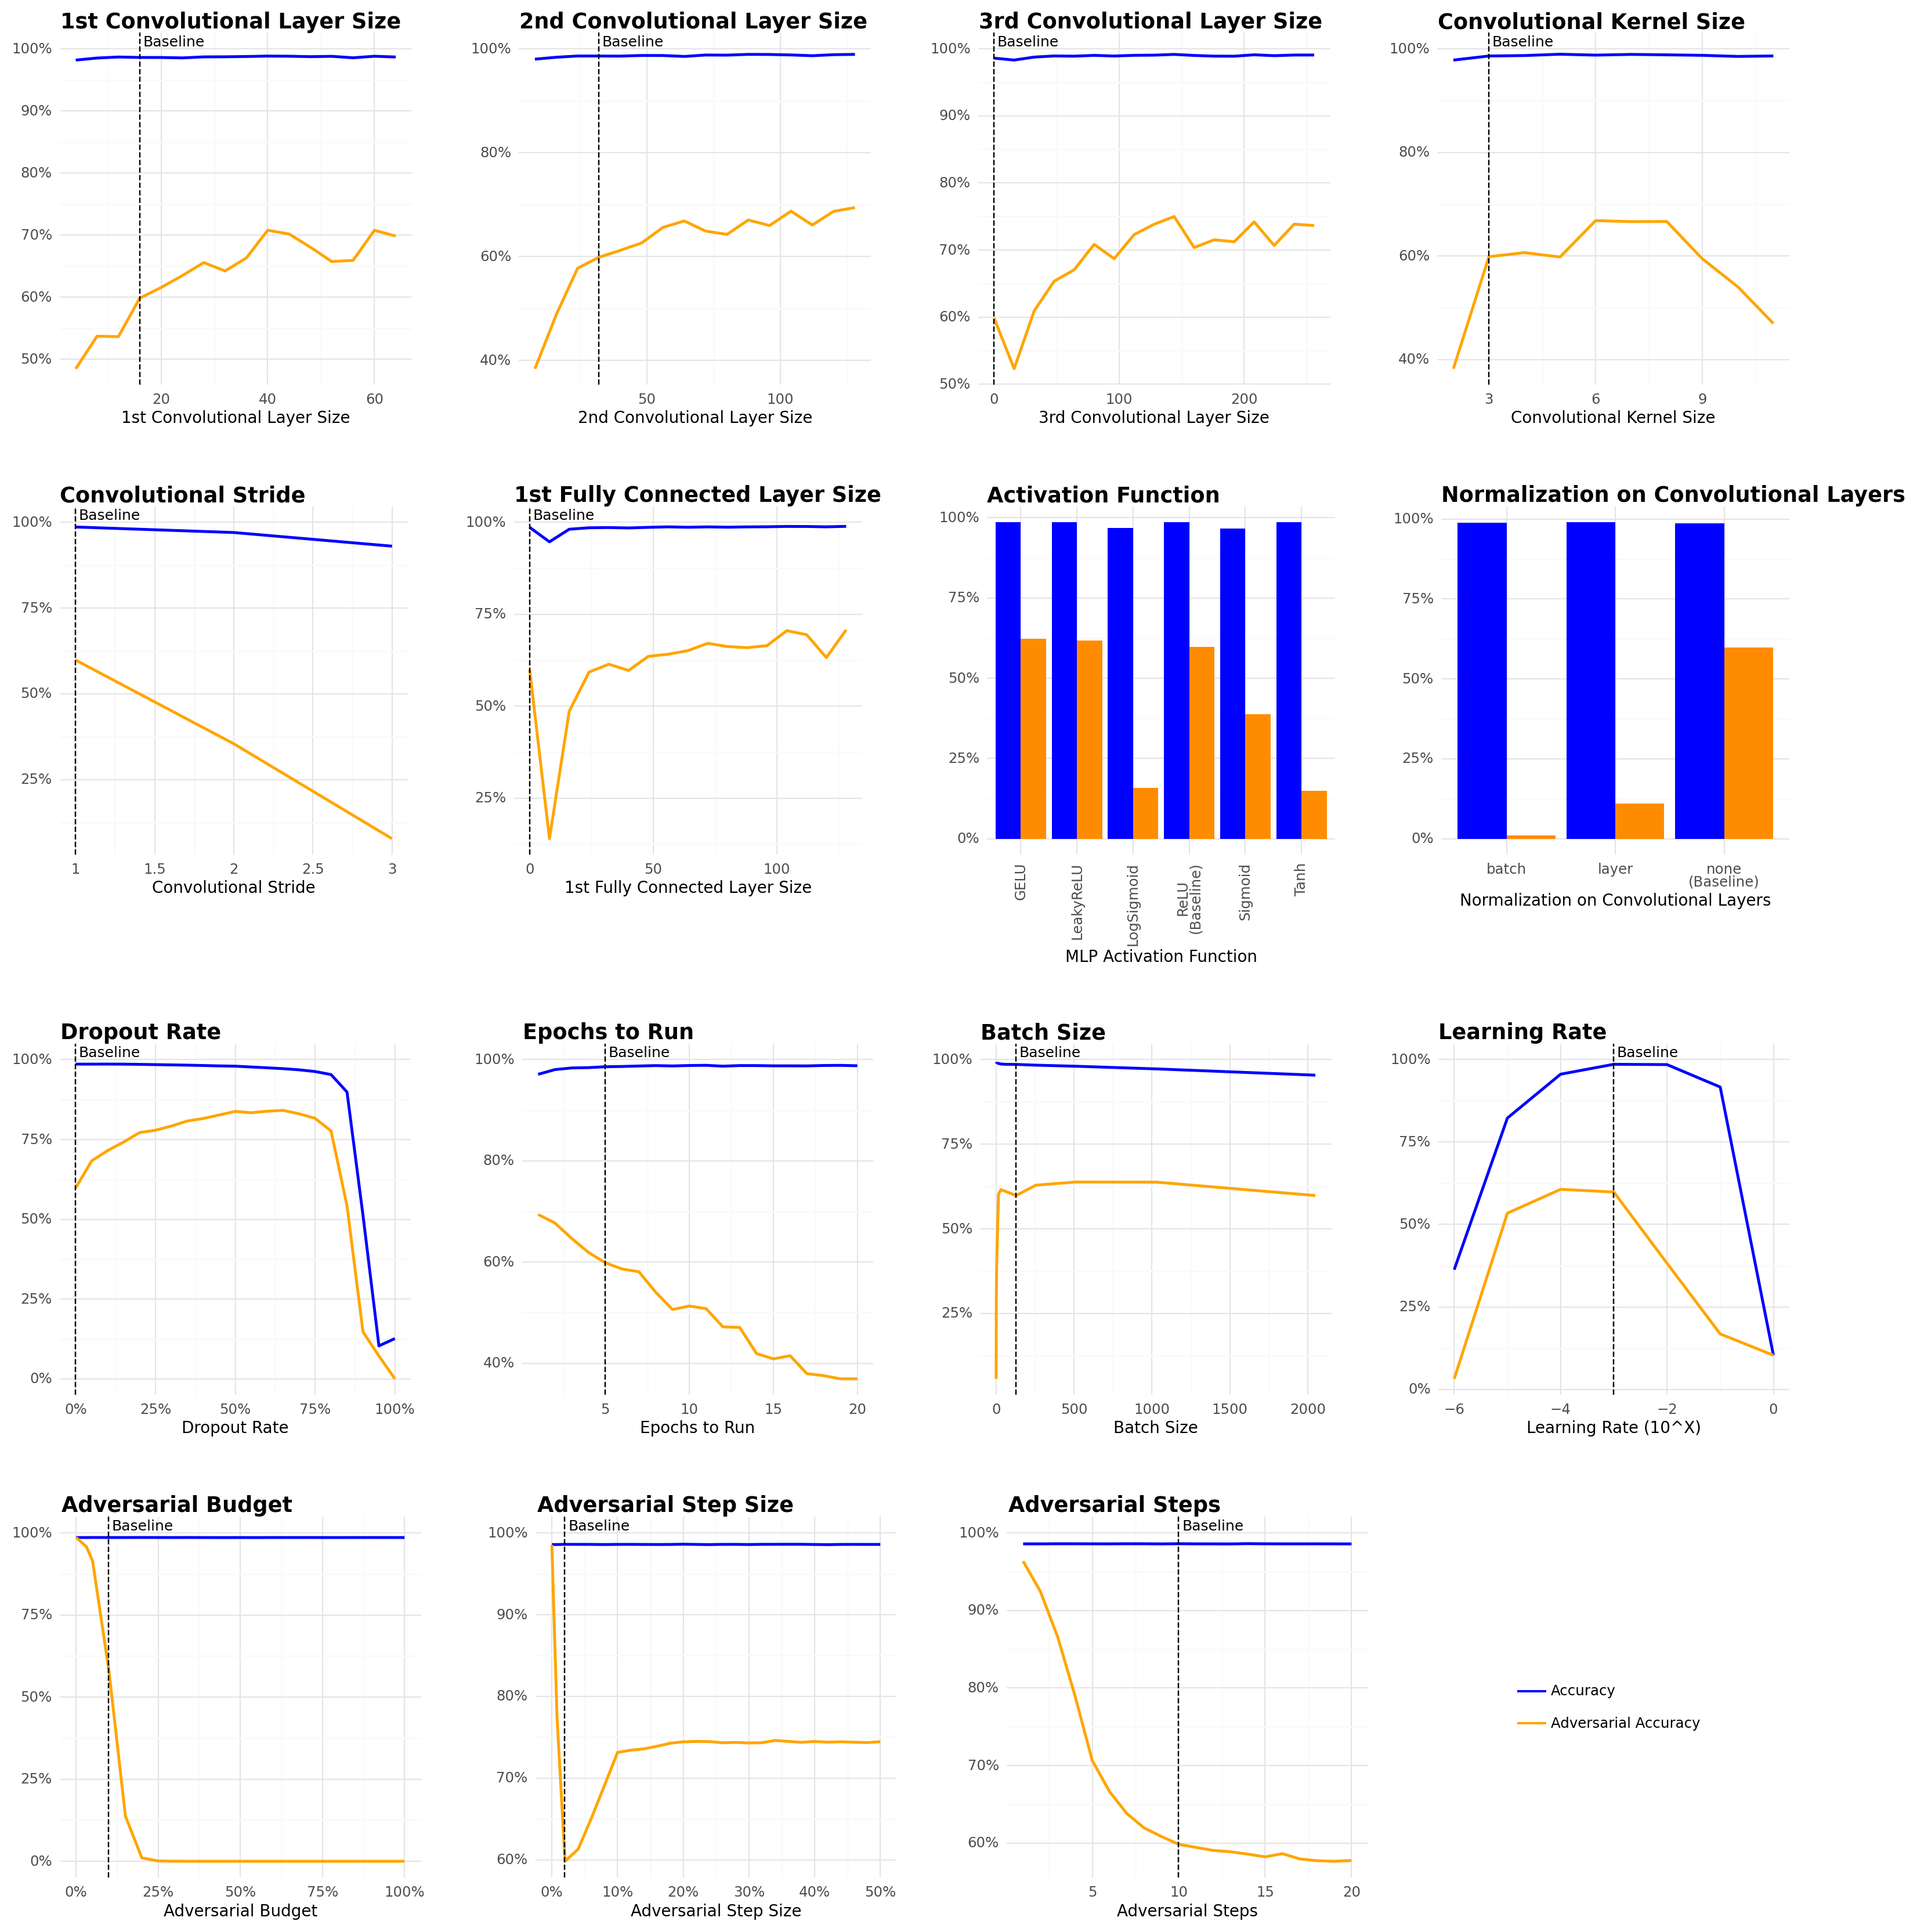

In [ ]:
bar_chart_vars = [
    "activation_function",
    "conv_normalization"
]
vars_to_plot = [
    "conv_layer_1",
    "conv_layer_2",
    "conv_layer_3",
    "conv_kernel",
    "conv_stride",
    "fully_connected_layer_1",
    "activation_function",
    "conv_normalization",
    "dropout",
    "epochs_to_run",
    "batch_size",
    "learning_rate",
    "eps",
    "alpha",
    "steps"
]
plot_kwargs = {
    "activation_function": {
        "rotate_x_axis_labels": True,
        "title": "Activation Function"
    },
    "dropout": {"var_is_percent": True},
    "learning_rate": {"log_var": True},
    "eps": {"var_is_percent": True},
    "alpha": {"var_is_percent": True}
}
combined_summary_plot(
    completed_cnn_experiments,
    vars_to_plot,
    plot_kwargs,
    metrics=["accuracy", "adv_accuracy"],
    num_rows=4
)

# Supplementary

## Adversarial Image Exploration

### Step 1: Train / Load a Trained Model

In [ ]:
model = ExperimentRun(VISION_TRANSFORMER_BASELINE).model

After 1 epoch(s):
  loss = 0.30284568667411804
  accuracy = 0.9111328125
After 2 epoch(s):
  loss = 0.23351165652275085
  accuracy = 0.93359375
After 3 epoch(s):
  loss = 0.1950281858444214
  accuracy = 0.9345703125
After 4 epoch(s):
  loss = 0.15487505495548248
  accuracy = 0.95458984375
After 5 epoch(s):
  loss = 0.17629998922348022
  accuracy = 0.94921875
Final result:
  loss = 0.1704288825392723
  accuracy = 0.9474000453948974
  adv_loss = 4.0269077062606815
  adv_accuracy = 0.2368000105023384
(0.86 min. training; 0.99 min. total)



### Step 2: Prepare Adversarial Images

In [ ]:
test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=len(test_data)  # Test on all test data
)

model.eval()
X, y = next(iter(test_data_loader))
X = X.to(DEVICE)
y = y.to(DEVICE)

atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=4)
adv_images = atk(X, y)
adv_images.shape

torch.Size([10000, 1, 28, 28])

### Step 3: Evaluate Adversarial Robustness

In [ ]:
logits, loss = model(adv_images, y)
accuracy = (F.softmax(logits, dim=1).argmax(dim=1) == y).float().mean()
print("loss =", loss.item())
print("accuracy =", accuracy.item())
print("")

loss = 4.028336048126221
accuracy = 0.23589999973773956



### View Adversarial Images

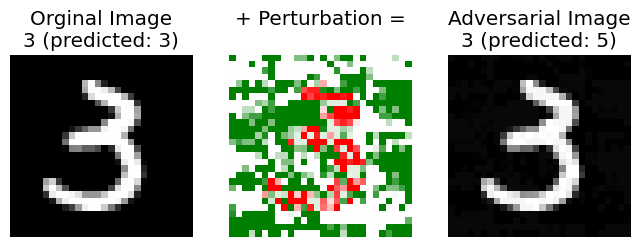

Equal? = False
Max Absolute Difference = 0.03137257695198059
Mean Absolute Difference = 0.01645584963262081


In [ ]:
def display_adversarial_attack_example(
    model,
    true_img,
    adv_img,
    true_label,
    show_perturbation=True,
    show_difference_diagnostics=True
):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 2, 1
    if show_perturbation:
      cols = 3

    predicted_true = model(true_img.view(1, 1, 28, 28)).argmax().item()
    predicted_adv = model(adv_img.view(1, 1, 28, 28)).argmax().item()

    # True image
    current_col = 1
    figure.add_subplot(rows, cols, current_col)
    plt.title(f"Orginal Image\n{true_label} (predicted: {predicted_true})")
    plt.axis("off")
    plt.imshow(true_img.squeeze().cpu(), cmap="gray")

    # Perturbation
    if show_perturbation:
        current_col += 1
        figure.add_subplot(rows, cols, current_col)
        plt.title("+ Perturbation =\n")
        plt.axis("off")
        eps = 8/255
        plt.imshow(
            (adv_img - true_img).squeeze().cpu(),
            cmap=LinearSegmentedColormap.from_list("rg", ["r", "w", "g"], N=256),
            vmin=-eps,
            vmax=eps
        )

    # Adversarial image
    current_col += 1
    figure.add_subplot(rows, cols, current_col)
    plt.title(f"Adversarial Image\n{true_label} (predicted: {predicted_adv})")
    plt.axis("off")
    plt.imshow(adv_img.squeeze().cpu(), cmap="gray")

    plt.show()

    if show_difference_diagnostics:
        print(f"Equal? = {torch.all(true_img == adv_img).item()}")
        print(f"Max Absolute Difference = {(true_img - adv_img).abs().max().item()}")
        print(f"Mean Absolute Difference = {(true_img - adv_img).abs().mean().item()}")

sample_idx = torch.randint(len(adv_images), size=(1,)).item()
display_adversarial_attack_example(
    model,
    true_img=X[sample_idx],
    adv_img=adv_images[sample_idx],
    true_label=y[sample_idx].item()
)

## Improved Vision Transformer Model vs. Baseline

In [24]:
# BASELINE MODEL:
Experiment(  #0.3806
  model_class="VisionTransformer",
  random_seed=[RANDOM_SEED],
  experiment_store=experiment_store
).df()

VisionTransformer: {'random_seed': 8888}
Loading saved experiment values...


,trained_by,start_time,train_start_time,train_end_time,end_time,random_seed,model_class,patch_size,model_dim,head_dim,...,learning_rate,adv_algorithm,eps,alpha,steps,loss,accuracy,adv_loss,adv_accuracy,safety_capability_ratio
0,Sean,1.701562e+09,1.701562e+09,1.701562e+09,1.701562e+09,8888,VisionTransformer,7,16,8,...,0.001,PGD,0.031373,0.007843,4,0.156486,0.9535,2.730092,0.3806,0.399161


In [25]:
# IMPROVED MODEL:
Experiment(  #0.9618
    layer_norm=["none"],
    dropout=[0.2],
    epochs_to_run=[20],
    model_dim=[40],
    num_layers=[8],
    num_heads=[6],
    head_dim=[32],
    mlp_dim=[124],
    QKV_bias=[False],
    **shared_vision_transformers_experiment_args
).df()

VisionTransformer: {'QKV_bias': False, 'dropout': 0.2, 'epochs_to_run': 20, 'head_dim': 32, 'layer_norm': 'none', 'mlp_dim': 124, 'model_dim': 40, 'num_heads': 6, 'num_layers': 8}
Loading saved experiment values...


,trained_by,start_time,train_start_time,train_end_time,end_time,random_seed,model_class,patch_size,model_dim,head_dim,...,learning_rate,adv_algorithm,eps,alpha,steps,loss,accuracy,adv_loss,adv_accuracy,safety_capability_ratio
0,Sean,1.702443e+09,1.702443e+09,1.702443e+09,1.702443e+09,8888,VisionTransformer,7,40,32,...,0.001,PGD,0.031373,0.007843,4,0.054151,0.9837,0.131086,0.9618,0.977737
